# Two Sigma: Rental Interest Competition

In [1]:
from IPython.display import display
import datetime
import gc
import itertools
import json
import operator
import os
import pandas as pd
import pickle
import pprint
import numpy as np
import re
import seaborn as sns
import spacy
import torch
import torch.optim as optim

from collections import Counter, deque
from pytorch_pretrained_bert import BertAdam
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    make_scorer,
    mean_squared_error
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from skorch.callbacks import (
    Callback,
    Checkpoint,
    EpochScoring,
    LRScheduler,
    ProgressBar,
    TrainEndCheckpoint
)

from utils.callbacks import SummarizeParameters
from utils.data import load_training_test_data
from utils.dataframe import (
    categories_from_column,
    column_list_to_category_flags,
    count_json_in_dataframes,
    count_ngrams_up_to_n,
    drop_columns_from_dataframes,
    map_categorical_column_to_category_ids,
    normalize_categories,
    normalize_description,
    numerical_feature_engineering_on_dataframe,
    parse_address_components,
    remove_outliers,
    remap_column,
    remap_columns_with_transform,
    remap_date_column_to_days_before,
    remove_small_or_stopwords_from_ranking
)
from utils.featurize import (
    featurize_for_tabular_models,
    featurize_for_tree_models,
)
from utils.gc import gc_and_clear_caches
from utils.doc2vec import (
    column_to_doc_vectors
)
from utils.model import (
    basic_logistic_regression_pipeline,
    basic_xgboost_pipeline,
    basic_adaboost_pipeline,
    basic_extratrees_pipeline,
    basic_svc_pipeline,
    basic_random_forest_pipeline,
    expand_onehot_encoding,
    format_statistics,
    get_prediction_probabilities_with_columns,
    get_prediction_probabilities_with_columns_from_predictions,
    prediction_accuracy,
    write_predictions_table_to_csv,
    rescale_features_and_split_into_continuous_and_categorical,
    split_into_continuous_and_categorical,
    test_model_with_k_fold_cross_validation,
    train_model_and_get_validation_and_test_set_predictions
)
from utils.language_models.bert import (
    BertClassifier,
    BertForSequenceClassification,
    TensorTuple,
    GRADIENT_ACCUMULATION_STEPS,
    WARMUP_PROPORTION,
    bert_featurize_data_frames,
    create_bert_model,
    create_bert_model_with_tabular_features,
)
from utils.language_models.descriptions import (
    descriptions_to_word_sequences,
    generate_bigrams,
    generate_description_sequences,
    maybe_cuda,
    postprocess_sequences,
    token_dictionary_seq_encoder,
    tokenize_sequences,
    torchtext_create_text_vocab,
    torchtext_process_texts,
    words_to_one_hot_lookups,
)
from utils.language_models.featurize import (
    featurize_sequences_from_dataframe,
    featurize_sequences_from_sentence_lists,
)
from utils.language_models.fasttext import (
    FastText,
    FastTextWithTabularData
)
from utils.language_models.simple_rnn import (
    CheckpointAndKeepBest,
    LRAnnealing,
    NoToTensorInLossClassifier,
    SimpleRNNPredictor,
    SimpleRNNTabularDataPredictor
)
from utils.language_models.split import (
    shuffled_train_test_split_by_indices,
    simple_train_test_split_without_shuffle_func,
    ordered_train_test_split_with_oversampling
)
from utils.language_models.textcnn import (
    TextCNN,
    TextCNNWithTabularData
)
from utils.language_models.ulmfit import (
    load_ulmfit_classifier_with_transfer_learning_from_data_frame,
    train_ulmfit_model_and_get_validation_and_test_set_predictions,
    train_ulmfit_classifier_with_gradual_unfreezing
)
from utils.language_models.visualization import (
    preview_tokenization,
    preview_encoded_sentences
)
from utils.report import (
    generate_classification_report_from_preds,
    generate_classification_report
)

nlp = spacy.load("en")

Check GPU support

In [2]:
torch.cuda.is_available()

True

## 1 Exploratory Data Analysis

In [3]:
(ALL_TRAIN_DATAFRAME, TEST_DATAFRAME) = \
  load_training_test_data(os.path.join('data', 'train.json'),
                          os.path.join('data', 'test.json'))
TRAIN_INDEX, VALIDATION_INDEX = train_test_split(ALL_TRAIN_DATAFRAME.index, test_size=0.1)
TRAIN_DATAFRAME = ALL_TRAIN_DATAFRAME.iloc[TRAIN_INDEX].reset_index()
VALIDATION_DATAFRAME = ALL_TRAIN_DATAFRAME.iloc[VALIDATION_INDEX].reset_index()
TEST_DATAFRAME = TEST_DATAFRAME.reset_index(drop=True)

## 1.1 Initial Data Visualization

Take all the numerical features and show some statistics on all of them.

Immediately we can tell the following:
 - Price seems to have a pretty high range on the log scale, going from $40 \to 449000$. That's not particularly helpful since we think this is probably a pretty important feature, so lets filter out some of the super-high priced stuff.
 - Most properties are within the sweet spot of "-74 to -73" longitude and "40.70 to 40.80 latitude". There's a few others that aren't, so maybe better to filter those out.
 - Clearly there is some bogus data. Some properties have a lat/long of 0 which is incorrect. Unfortunately this also exists on the test set, but there are probably so few that we don't care.

In [4]:
ALL_TRAIN_DATAFRAME.head()

,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
1,6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
2,9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
3,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
4,15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


In [5]:
ALL_TRAIN_DATAFRAME.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [6]:
TEST_DATAFRAME.head()

,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
2,2,1.0,0,0,2016-06-17 01:23:39,Spacious studio in Prime Location. Cleanbuildi...,Sullivan Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7174566_ba3a35c5...,2295,115 Sullivan Street
3,3,1.0,2,f9c826104b91d868e69bd25746448c0c,2016-06-21 05:06:02,For immediate access call Bryan.<br /><br />Bo...,Jones Street,"[Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,[https://photos.renthop.com/2/7191391_8c2f2d49...,2900,23 Jones Street
4,5,1.0,1,81062936e12ee5fa6cd2b965698e17d5,2016-06-16 07:24:27,Beautiful TRUE 1 bedroom in a luxury building ...,Exchange Place,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,[https://photos.renthop.com/2/7171695_089ffee2...,3254,20 Exchange Place


In [7]:
TEST_DATAFRAME.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,7.465900e+04
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,3.749033e+03
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,9.713092e+03
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,2.495000e+03
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,4.100000e+03
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,1.675000e+06


In [8]:
CORE_NUMERICAL_COLUMNS = ['bathrooms', 'bedrooms', 'price', 'latitude', 'longitude']

In [9]:
NUMERICAL_QUANTILES = {
    'bathrooms': (0.0, 0.999),
    'bedrooms': (0.0, 0.999),
    'latitude': (0.01, 0.99),
    'longitude': (0.01, 0.99),
    'price': (0.01, 0.99)
}

We can then run a pairplot analysis on both the training and test dataframes and notice that while there isn't much correlation between price and amenities, there is quite a big correlation between things like price and location. Properties in pricier areas tend to have more amenities.

The cell for the correlation between latitude and longitude looks a little bit like the Greater New York area.

Price wise, most properties are sitting in the $2000-4000 range, steeply dropping off after that. Also, there are definitely "pricey" and "cheap" areas, with most of the cheaper properties sitting in the -73.85 to -73.95 longitude.

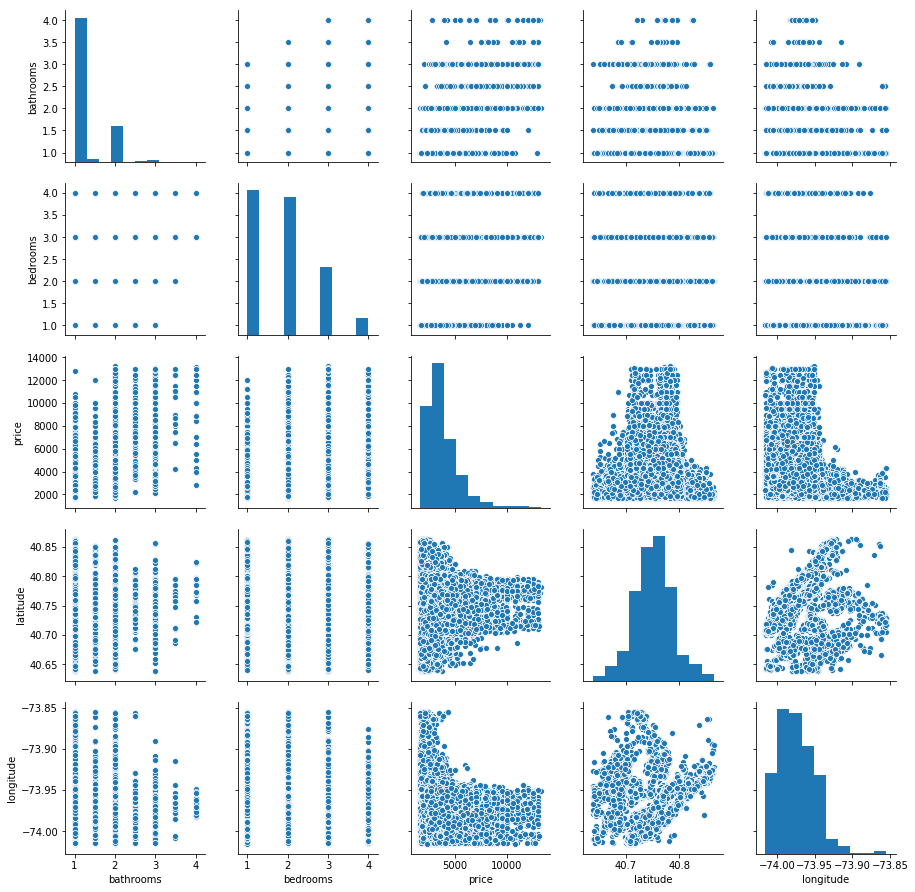

In [10]:
sns.pairplot(remove_outliers(ALL_TRAIN_DATAFRAME[CORE_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

The test set is distributed in a simialr way, though it has more properties to the north and south east.

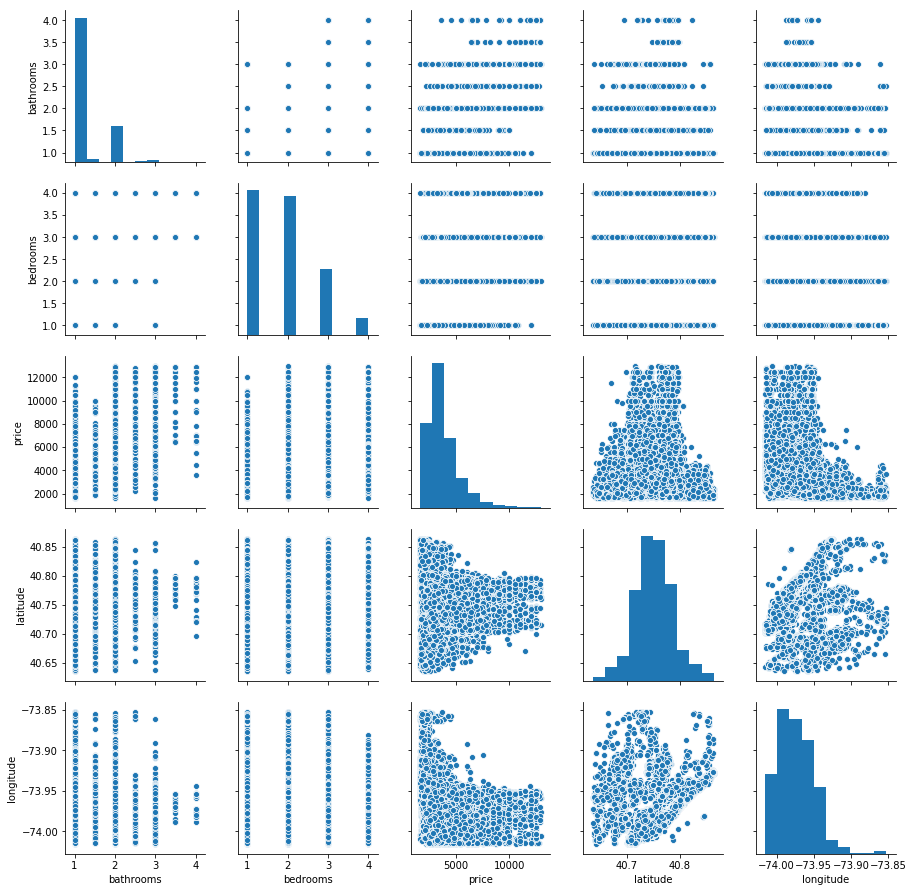

In [11]:
sns.pairplot(remove_outliers(TEST_DATAFRAME[CORE_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

## 1.2 Outlier Removal

Lets remove our outliers the training set.

In [12]:
TRAIN_DATAFRAME = remove_outliers(TRAIN_DATAFRAME, NUMERICAL_QUANTILES)

## 2 Data Cleaning and Feature Engineering

Let's see what this table looks like. We'll display the head of the table which shows its features

In [13]:
TRAIN_DATAFRAME.head()

,index,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,20018,50465,1.0,1,5fb96990fbab79e8b88707fb477eec2f,2016-05-19 03:12:12,Enjoy this spacious 1 bedroom with unobstructe...,John St.,"[Dining Room, Doorman, Elevator, Fitness Cente...",40.7084,7036990,-74.0066,614e9c02bcb1b7feaff502d4c1203c47,[https://photos.renthop.com/2/7036990_52632ded...,3195,85 John St.,low
1,2184,5537,1.0,2,bbc28059df5e21c49c103c46743631d4,2016-06-16 07:58:47,Lovely and spacious 2 Bed / 1 Bath apartment w...,Thompson Street,"[Dishwasher, Hardwood Floors, Outdoor Space]",40.7277,7172608,-74.0000,2451d781a4d2e23ee30cfd0caae3246f,[https://photos.renthop.com/2/7172608_4d6b7509...,4095,174 Thompson Street,medium
2,30476,76483,1.0,1,d0234abbc01a982d54e8d446acc03405,2016-05-08 04:25:23,Luxury Doorman Building- Full Service- Valet- ...,West 34th Street,"[Doorman, Fitness Center, Laundry in Building,...",40.7530,6983640,-73.9958,e1c98bf7f1a044ec4df76abee5f0f5e6,[https://photos.renthop.com/2/6983640_5b369afd...,3125,360 West 34th Street,medium
3,32010,80437,1.0,3,33e66addeae3fe97ff874673e0479ca3,2016-05-18 04:31:46,"Perfect for roommates, Prime area, Pri...",Union St,[],40.6764,7029929,-73.9808,324631e1aacaa41bc4475f879756bbb6,[https://photos.renthop.com/2/7029929_d2c7c6b3...,3600,688 Union St,low
4,13245,33364,1.0,5,cfe39edc46a4851c334b937285f6c76d,2016-06-14 16:28:54,"This is a great, renovated 3 bedroom apartment...",W 14th St,"[Common Outdoor Space, Laundry In Unit, Cats A...",40.7391,7160646,-74.0016,b0bea7357fc07d2716c68644dc8a312c,[https://photos.renthop.com/2/7160646_9353866d...,6295,234 W 14th St,low


### 2.1) Cleaning up categories

Let's clean up the categories and put them into a sensible vector. Unfortunately the categories are a bit of a mess - since the user can specify what categories they want there isn't much in the way of consistency between categories.

Some of the patterns that we frequently see in the categories are:
 - Separating category names with "**"
 - Mix of caps/nocaps
 - Some common themes, such as:
   - "pets"
   - "office"
   - "living room"
   - "garden"
   - "common area"
   - "storage"
   - "no pets"
   - "parking"
   - "bicycle"
   - "doorman"
   - etc

To deal with this, lets pull out all of the categories and normalize them
by removing excess punctuation, normalizing for whitespace, lowercasing, and counting for certain n-grams.

In [14]:
normalized_categories = sorted(normalize_categories(categories_from_column(TRAIN_DATAFRAME, 'features')))
normalized_categories[:50]

['$1000. move in visa giftcard will be handed to new tenants upon rental lease signing',
 '$1500. move in visa giftcard will be handed to new tenants upon rental lease signing',
 '$250 application fee with background and credit check. board interview and approval.',
 '$250 security deposit',
 '$500 security deposit',
 '$600 gift card for move ins prior to june 19',
 '000 sf fitness center',
 '000 square foot exclusive courtyard oasis for via residents',
 '1 br or conv 2',
 "1 mo broker's fee 18 mo lease",
 '1 month free',
 '1 month free',
 '1 month free',
 '1 month free rent',
 '1.5 bath',
 '1.5 bathrooms',
 '1.5 baths',
 '1.5 baths',
 '1.5 marble baths',
 '1/2 bath',
 '1/2 month fee',
 '1100 sq ft',
 '1200sq ft',
 '12th st 3rd ave',
 '1st',
 '2 beautifully furnished outside sundecks',
 '2 bedroon convertible',
 '2 blocks away from union square',
 '2 full bathrooms',
 '2 full baths',
 '2 months free',
 '2 queen bedrooms',
 '2 story tenant lounge',
 '2 year lease',
 '22',
 '24 hour atte

Now that we have our slightly tidied up categories, we can create some n-grams and count their frequency

In [15]:
most_common_ngrams = sorted(count_ngrams_up_to_n(" ".join(normalized_categories), 3).most_common(),
                            key=lambda x: (-x[1], x[0]))
most_common_ngrams[:50]

[('', 4939),
 ('in', 105),
 ('kitchen', 100),
 ('to', 71),
 ('room', 70),
 ('home', 60),
 ('2br', 50),
 ('fee', 48),
 ('of', 47),
 ('no', 45),
 ('super', 45),
 ('the', 45),
 ('private', 44),
 ('2', 42),
 ('massive', 41),
 ('windows', 38),
 ('and', 37),
 ('on', 37),
 ('new', 36),
 ('share', 36),
 ('no fee', 34),
 ('deck', 33),
 ('l', 32),
 ('sprawling', 32),
 ('storage', 31),
 ('bldg', 30),
 ('eat', 30),
 ('eat in', 30),
 ('huge', 30),
 ('in kitchen', 30),
 ('laundry', 30),
 ('park', 30),
 ('blks', 28),
 ('blks to', 28),
 ('1br', 27),
 ('renovated', 27),
 ('3br', 26),
 ('all', 26),
 ('on site', 25),
 ('roof', 25),
 ('site', 25),
 ('ok', 24),
 ('pets', 24),
 ('bedford', 23),
 ('bedford l', 23),
 ('large', 23),
 ('lounge', 23),
 ('parking', 23),
 ('super share', 23),
 ('1br home', 22)]

There's quite a few words here that don't add much value. We can remove them by consulting a list of stopwords

In [16]:
most_common_ngrams = sorted(list(remove_small_or_stopwords_from_ranking(most_common_ngrams, nlp, 3)),
                            key=lambda x: (-x[1], x[0]))
most_common_ngrams[:50]

[('kitchen', 100),
 ('room', 70),
 ('home', 60),
 ('2br', 50),
 ('fee', 48),
 ('super', 45),
 ('private', 44),
 ('massive', 41),
 ('windows', 38),
 ('new', 36),
 ('share', 36),
 ('no fee', 34),
 ('deck', 33),
 ('sprawling', 32),
 ('storage', 31),
 ('bldg', 30),
 ('eat', 30),
 ('eat in', 30),
 ('huge', 30),
 ('in kitchen', 30),
 ('laundry', 30),
 ('park', 30),
 ('blks', 28),
 ('blks to', 28),
 ('1br', 27),
 ('renovated', 27),
 ('3br', 26),
 ('on site', 25),
 ('roof', 25),
 ('site', 25),
 ('pets', 24),
 ('bedford', 23),
 ('bedford l', 23),
 ('large', 23),
 ('lounge', 23),
 ('parking', 23),
 ('super share', 23),
 ('1br home', 22),
 ('2br home', 22),
 ('free', 22),
 ('outdoor', 22),
 ('terrace', 22),
 ('2 blks', 21),
 ('doorman', 21),
 ('oversized', 21),
 ('space', 21),
 ('train', 21),
 ('unit', 21),
 ('clean', 20),
 ('closets', 19)]

Now that we have these, we can probably take 100 most common and arrange
them into category flags for our table

In [17]:
TRAIN_DATAFRAME = column_list_to_category_flags(TRAIN_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))
VALIDATION_DATAFRAME = column_list_to_category_flags(VALIDATION_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))
TEST_DATAFRAME = column_list_to_category_flags(TEST_DATAFRAME, 'features', list(map(operator.itemgetter(0), most_common_ngrams[:100])))

In [18]:
TRAIN_DATAFRAME.head(5)

,index,id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,...,features_living_room,features_luxury,features_rent,features_village,features_ave,features_fireplace,features_high,features_massive_1br,features_natural_light,features_perfect
0,20018,50465,1.0,1,5fb96990fbab79e8b88707fb477eec2f,2016-05-19 03:12:12,Enjoy this spacious 1 bedroom with unobstructe...,John St.,"[Dining Room, Doorman, Elevator, Fitness Cente...",40.7084,...,0,0,0,0,0,0,0,0,0,0
1,2184,5537,1.0,2,bbc28059df5e21c49c103c46743631d4,2016-06-16 07:58:47,Lovely and spacious 2 Bed / 1 Bath apartment w...,Thompson Street,"[Dishwasher, Hardwood Floors, Outdoor Space]",40.7277,...,0,0,0,0,0,0,0,0,0,0
2,30476,76483,1.0,1,d0234abbc01a982d54e8d446acc03405,2016-05-08 04:25:23,Luxury Doorman Building- Full Service- Valet- ...,West 34th Street,"[Doorman, Fitness Center, Laundry in Building,...",40.7530,...,0,0,0,0,0,0,0,0,0,0
3,32010,80437,1.0,3,33e66addeae3fe97ff874673e0479ca3,2016-05-18 04:31:46,"Perfect for roommates, Prime area, Pri...",Union St,[],40.6764,...,0,0,0,0,0,0,0,0,0,0
4,13245,33364,1.0,5,cfe39edc46a4851c334b937285f6c76d,2016-06-14 16:28:54,"This is a great, renovated 3 bedroom apartment...",W 14th St,"[Common Outdoor Space, Laundry In Unit, Cats A...",40.7391,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Cleaning up listing_date

We can also do something useful with the listing date - it may be better to say how many days ago the property was listed - older properties are probably going to get a lot less interest than newer properties.

In [19]:
TRAIN_DATAFRAME = remap_date_column_to_days_before(TRAIN_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))
VALIDATION_DATAFRAME = remap_date_column_to_days_before(VALIDATION_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))
TEST_DATAFRAME = remap_date_column_to_days_before(TEST_DATAFRAME, "created", "created_days_ago", datetime.datetime(2017, 1, 1))

In [20]:
TRAIN_DATAFRAME["created_days_ago"].head(5)

0    226
1    198
2    237
3    227
4    200
Name: created_days_ago, dtype: int64

### 2.3 Cleaning up interest_level

Right now the interest level is encoded on a scale of "Low, Medium, High". The competition
wants us to classify the entries in to each, so we assign a label

In [21]:
INTEREST_LEVEL_MAPPINGS = {
    "high": 0,
    "medium": 1,
    "low": 2
}

TRAIN_DATAFRAME = remap_column(TRAIN_DATAFRAME, "interest_level", "label_interest_level", lambda x: INTEREST_LEVEL_MAPPINGS[x])
VALIDATION_DATAFRAME = remap_column(VALIDATION_DATAFRAME, "interest_level", "label_interest_level", lambda x: INTEREST_LEVEL_MAPPINGS[x])
# The TEST_DATAFRAME does not have an interest_level column, so we
# instead add it and replace it with all zeros
TEST_DATAFRAME["label_interest_level"] = 0

In [22]:
TRAIN_DATAFRAME["label_interest_level"].head(5)

0    2
1    1
2    1
3    2
4    2
Name: label_interest_level, dtype: int64

### 2.4 Cleaning up building_id, manager_id

`building_id` and `manager_id` look a bit useless to us on the outside, but according to https://www.kaggle.com/den3b81/some-insights-on-building-id they are actually quite predictive of interest since 20% of the manager make up 80% of the rentals (we can also see this in their writing style as well).

Since there aren't too many managers or buildings in total, we can convert these into category ID's where we'll pass them through an embedding later on.

Note that we need to do this over both dataframes - since there could
be some managers that are in the test dataframe which are not in the training dataframe and vice versa.

Note that we want to lump all the "misc" buildings and managers together
into a single building or manager since listings by "non-property managers" or "non-frequently-rented-buildings" are different from ones run by property managers.

In [23]:
((BUILDING_ID_UNKNOWN_REMAPPING,
  BUILDING_CATEGORY_TO_BUILDING_ID,
  BUILDING_CATEGORY_TO_BUILDING_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'building_id',
    'building_id_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

In [24]:
((MANAGER_ID_UNKNOWN_REMAPPING,
  MANAGER_ID_TO_MANAGER_CATEGORY,
  MANAGER_CATEGORY_TO_MANAGER_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'manager_id',
    'manager_id_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

### 2.5 Parsing and Separating Out Address Components
Some properties might be in the same neighbourhood, the same street or
part of the same building. If we separate out the address components then
we might be able to get some more meaningful feature groupings.

We first parse all the components into their own columns and then map them into categories (dropping them later on).

In [25]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = parse_address_components(
    [
        "display_address",
        "street_address"
    ],
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

In [26]:
((DISP_ADDR_ID_UNKNOWN_REMAPPING,
  DISP_ADDR_ID_TO_DISP_ADDR_CATEGORY,
  DISP_ADDR_CATEGORY_TO_DISP_ADDR_ID),
 (TRAIN_DATAFRAME,
  VALIDATION_DATAFRAME,
  TEST_DATAFRAME)) = map_categorical_column_to_category_ids(
    'display_address_normalized',
    'display_address_category',
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
    min_freq=40
)

### 2.6 Counting Number of Photos
The number of photos a place has might be predictive of its interest as well, so lets at least count the number of photos.

In [27]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = count_json_in_dataframes(
    "photos",
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

### 2.7 Feature Engineering on Numerical Columns
Some models can't do simple math, but ratios or additions/subtractions
between things might be important. Lets do that now for all of our
numerical data, but only for XGBoost, later

In [28]:
NUMERICAL_COLUMNS = CORE_NUMERICAL_COLUMNS + [
    'photos_count'
]

### 2.8 Cleaning Description
The text in the descriptions are pretty messy. We can clean it up by applying some normalization (eg, removing repeated symbols, normalizing whitespace, etc)

In [29]:
(TRAIN_DATAFRAME,
 VALIDATION_DATAFRAME,
 TEST_DATAFRAME) = remap_columns_with_transform(
    'description',
    'clean_description',
    normalize_description,
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME,
)

### 2.9 Drop unnecessary columns

Now that we have made our data nicer to work with, we can drop all the text-only columns and keep a "features" dataset, eg one that can be fed into our models (with a little extra work)

In [30]:
DROP_COLUMNS = [
    'id',
    'index',
    'created',
    'building_id',
    'clean_description',
    'description',
    'features',
    'display_address',
    'display_address_normalized',
    # We keep listing_id in the dataframe
    # since we'll need it later
    # 'listing_id',
    'manager_id',
    'photos',
    'street_address',
    'street_address_normalized',
    'interest_level',
]

In [31]:
(FEATURES_TRAIN_DATAFRAME,
 FEATURES_VALIDATION_DATAFRAME,
 FEATURES_TEST_DATAFRAME) = drop_columns_from_dataframes(
    DROP_COLUMNS,
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME
)

In [32]:
FEATURES_TRAIN_DATAFRAME.head(5)

,bathrooms,bedrooms,latitude,listing_id,longitude,price,features_kitchen,features_room,features_home,features_2br,...,features_high,features_massive_1br,features_natural_light,features_perfect,created_days_ago,label_interest_level,building_id_category,manager_id_category,display_address_category,photos_count
0,1.0,1,40.7084,7036990,-74.0066,3195,0,1,0,0,...,0,0,0,0,226,2,151,262,118,4
1,1.0,2,40.7277,7172608,-74.0000,4095,0,0,0,0,...,0,0,0,0,198,1,307,101,202,7
2,1.0,1,40.7530,6983640,-73.9958,3125,0,0,0,0,...,0,0,0,0,237,1,397,590,460,5
3,1.0,3,40.6764,7029929,-73.9808,3600,0,0,0,0,...,0,0,0,0,227,2,307,146,205,4
4,1.0,5,40.7391,7160646,-74.0016,6295,0,0,0,0,...,0,0,0,0,200,2,396,420,427,6


### 2.10 Visualizing Again

We can do the pairplots again now that we have featurized a little bit more and also to validate that our train/test split makes sense.

Its hard to visualize categorical features in a pairplot so we don't do that. Instead, we visualize the photos_count and label_interest level to see if any feature in particular is highly correlated with the interest level.

We find that at least on both the training and validation data, nothing *really* is, except perhaps the latitude and longitude, indicating that location seems to be the most important factor in determining how much interest a property gets.

Also, the numbert of photos is *negatively* correlated with interest (properties with more photos) had less interest overall.

The bottom right hand corner of the pairplot matrix tells us something particularly useful which is the class (im)balance. We have lots of properties with low interest (2) and few properties with high interest. This will be a challenge for us to deal with later. We tried over-sampling by duplicating but that didn't really help validation scores at all. There are also other oversampling techniques like SMOTE but they don't work with non-numeric data.

In [33]:
FEATURIZED_NUMERICAL_COLUMNS = CORE_NUMERICAL_COLUMNS + ["photos_count", "label_interest_level"]

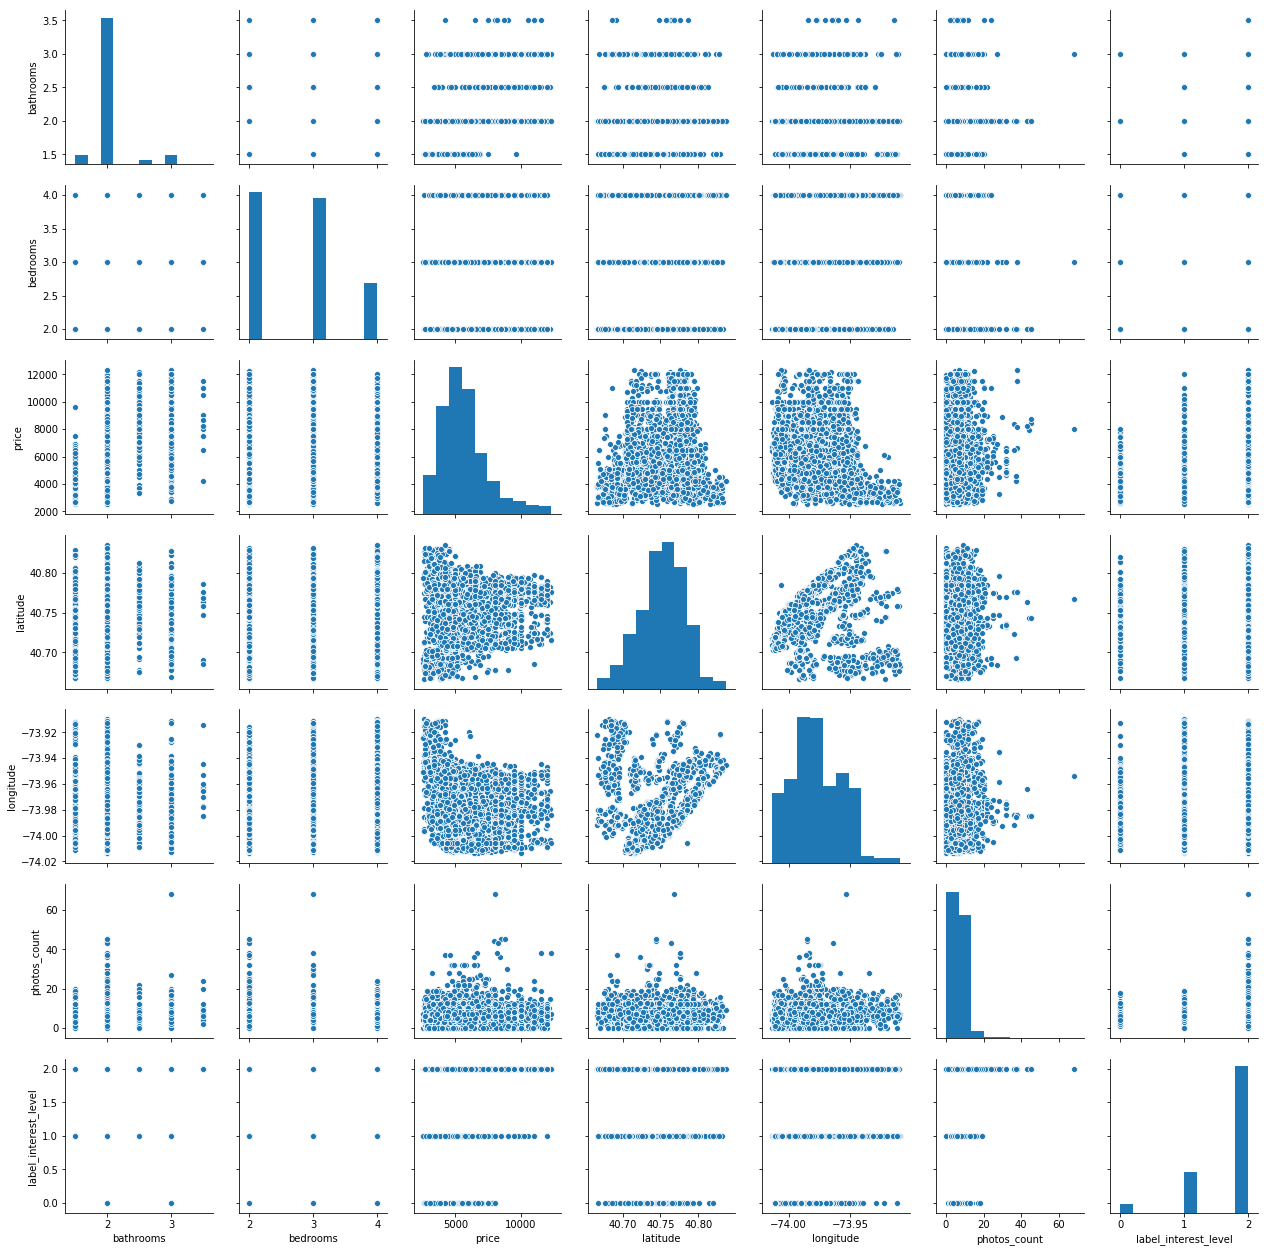

In [34]:
sns.pairplot(remove_outliers(FEATURES_TRAIN_DATAFRAME[FEATURIZED_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

We compare the validation split to the test data above to ensure that that we're sampling from a similar distribution. On the whole, we appear to be - the distribution of labels is about the same and this seems to have leaked into the distribution of proeprties geogrpahically (though the test data seems to have more properties from the northeastern peninsula). With a bit more time we probably could have tried to address this problem by also stratifying the validation split so that we included properties from that region, too.

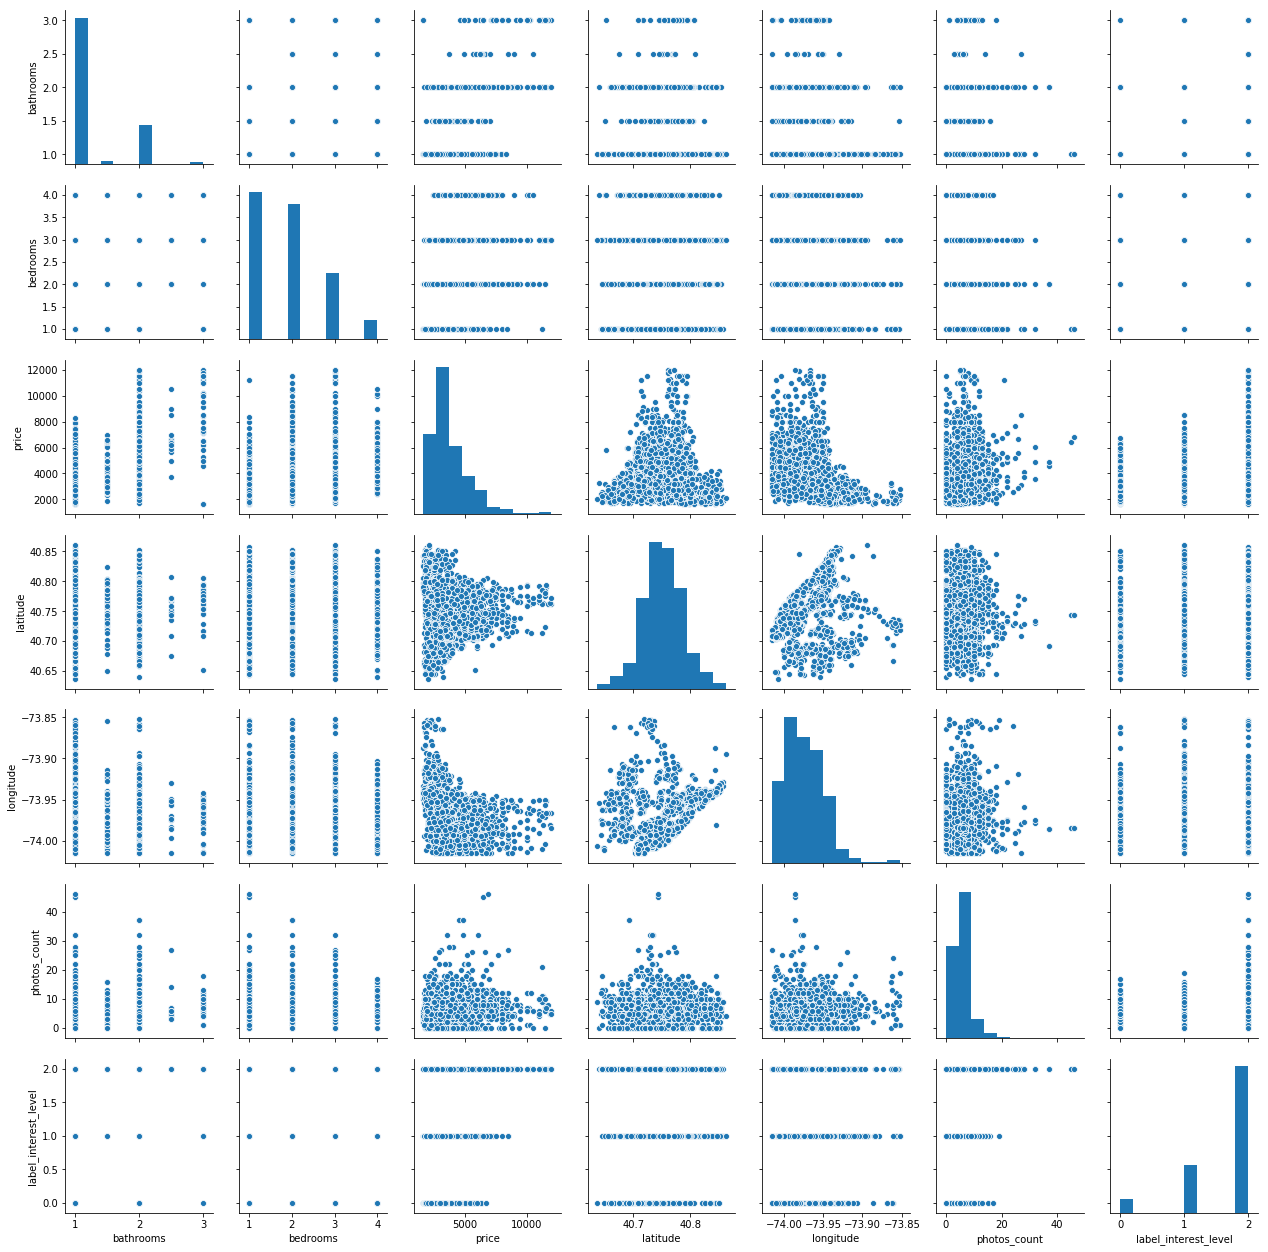

In [35]:
sns.pairplot(remove_outliers(FEATURES_VALIDATION_DATAFRAME[FEATURIZED_NUMERICAL_COLUMNS],
                             NUMERICAL_QUANTILES))

Finally, test set: we don't have the labels here (obviously), but we do have the count of photos. We get similar-ish distributions, properties with a higher photo count tend to be a little more expensive, but not much new information there.

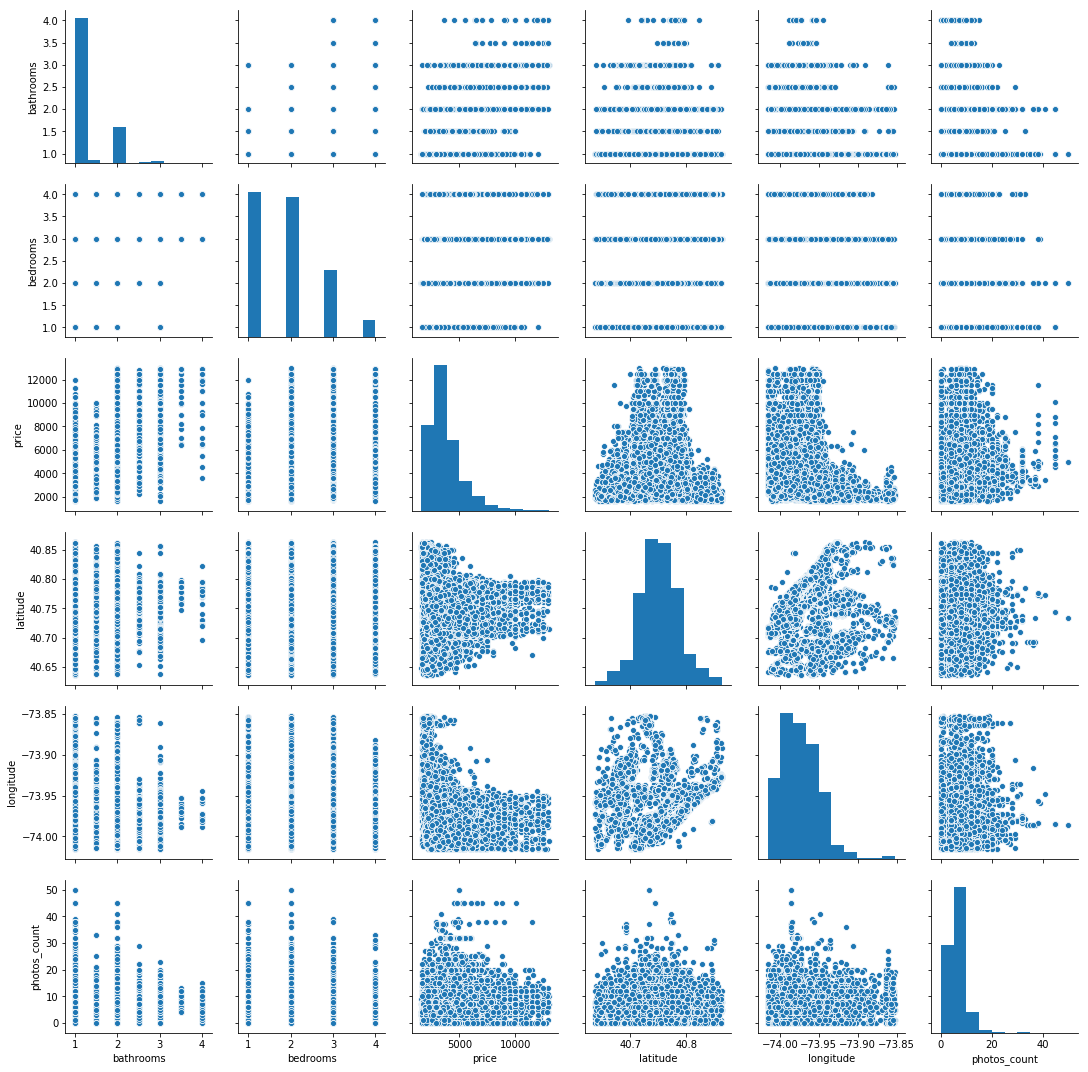

In [36]:
sns.pairplot(remove_outliers(FEATURES_TEST_DATAFRAME[FEATURIZED_NUMERICAL_COLUMNS[:-1]],
                             NUMERICAL_QUANTILES))

## 3) Fitting models

Now we can try out a few models and see what works well for the data that
we have so far.

In [37]:
CATEGORICAL_FEATURES = {
    'building_id_category': len(BUILDING_CATEGORY_TO_BUILDING_ID),
    'manager_id_category': len(MANAGER_ID_TO_MANAGER_CATEGORY),
    'display_address_category': len(DISP_ADDR_ID_TO_DISP_ADDR_CATEGORY)
}

For convenience, pull out the labels for training

In [38]:
TRAIN_LABELS = FEATURES_TRAIN_DATAFRAME['label_interest_level']
VALIDATION_LABELS = FEATURES_VALIDATION_DATAFRAME['label_interest_level']

### 3.1 Logistic Regression

This is just baseline Logistic Regression. The 'C' parameter is a regularization strength.

The 'penalty' paramter specifies the regularization penalty to be applied. 'l2' is the default, which basically
prevents any one particular weight from getting too large. 'l1' promotes sparse solutions.

In [39]:
def train_logistic_regression_model(data_info,
                                    featurized_train_data,
                                    featurized_validation_data,
                                    train_labels,
                                    validation_labels,
                                    train_param_grid_optimal=None):
    pipeline = basic_logistic_regression_pipeline(featurized_train_data,
                                                  train_labels,
                                                  CATEGORICAL_FEATURES,
                                                  param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline


def predict_with_sklearn_estimator(model, data):
    return model.predict(data), model.predict_proba(data)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   53.6s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   54.2s finished
Best parameters {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}
Label was 0, classified as 0


,description
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
134,This apartment is situated in a luxury elevato...
147,This Newly Renovated 3BR Apartment Features Hi...
297,Renovated three bedroom in a Prime Midtown Eas...
344,StuyTown offers an unbeatable combination of c...


Label was 0, classified as 1


,description
39,Live in the heart of SoHo for a fraction of th...
54,
73,"This beautiful newly renovated 1 bedroom, 1 ba..."
77,Amazing 2 bedroom apartment in beautif...
145,"WELCOME TO THIS MODERN MASTER PIECE,A PET FRIE..."


Label was 0, classified as 2


,description
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...
86,Gut renovated 2 rooms studio apartment locate...
107,No Fee!\rFurnished or Unfurnished\rAll apartme...
115,True 2 bedroom apartment on 3rd floor of class...


Label was 1, classified as 0


,description
356,Large Jr4 room.
396,Beautiful 2 Bed apartment in bustling ...
778,Huge Jr4 With Plenty Of Room. Jr4 Is B...
891,No Fee apt in Bushwick. Available now.<br>J &...
1113,NO FEE ..... AMAZING UNIT!! 2 BR 1 BA -- wash...


Label was 1, classified as 1


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
38,"Newly renovated with Dishwasher, washer/dryer,..."
41,::: Apartment Features :::* Renovated 4 Bedroo...
46,"29TH! PRIME KIPS BAY, HIGH FLOOR, LARGE FLEX 2..."


Label was 1, classified as 2


,description
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...
20,This classic Lower East Side 1BR comes at a pr...
27,Featuring a spacaious One Bedroom unit in a we...


Label was 2, classified as 0


,description
80,A detailed description is coming soon. Please ...
958,New to Market. Will be fully renovated. New Ha...
1246,Spacious three bedroom apartment encompassing ...
1456,LOCATION: 143rd &amp; AmsterdamCall Corey to v...
1471,StuyTown offers an unbeatable combination of c...


Label was 2, classified as 1


,description
26,FANTASTIC studio apartment located on the Uppe...
35,<center><strong><font color=#006600>- <u>NO FE...
51,THIS IS THE BEST PRICED TRUE 2 BEDROOM UNIT IN...
59,NO BROKERS FEE! This apartment is located in a...
70,* MUST SEE *WALK OUT OF YOUR OWN BOUTIQUE BUIL...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.11      0.49      0.18        87
           1       0.31      0.46      0.37       757
           2       0.92      0.77      0.84      4092

   micro avg       0.72      0.72      0.72      4936
   macro avg       0.45      0.58      0.47      4936
weighted avg       0.81      0.72      0.76      4936

Logistic loss 0.63221


None

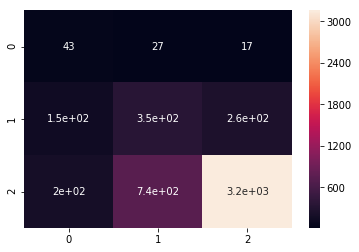

In [40]:
(LOGISTIC_REGRESSION_MODEL_VALIDATION_PROBABILITIES,
 LOGISTIC_REGRESSION_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tabular_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_logistic_regression_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'C': [1.0],
            'class_weight': [None],
            'penalty': ['l2']
        }
    )
)

In [41]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        LOGISTIC_REGRESSION_MODEL_TEST_PROBABILITIES,
    ),
    'renthop_logistic_regression_submissions.csv'
)

### 3.2 XGBoost

XGBoost is a histogram based model that applies boosting to an ensemble of weaker learners (decision trees). It generally performs quite well on Kaggle competitions and is also another baseline to use.

In [42]:
def train_xgboost_model(data_info,
                        featurized_train_data,
                        featurized_validation_data,
                        train_labels,
                        validation_labels,
                        train_param_grid_optimal=None):
    pipeline = basic_xgboost_pipeline(featurized_train_data,
                                      train_labels,
                                      tree_method=(
                                          # 'gpu_hist' turned out to be a lot slower
                                         'hist'
                                      ),
                                      param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   43.9s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   45.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   45.1s finished
[01:01:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Best parameters {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}
Label was 0, classified as 0


,description
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
77,Amazing 2 bedroom apartment in beautif...
107,No Fee!\rFurnished or Unfurnished\rAll apartme...
115,True 2 bedroom apartment on 3rd floor of class...
305,This is an Efficiency Studio at a great Price ...


Label was 0, classified as 1


,description
54,
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."
86,Gut renovated 2 rooms studio apartment locate...
134,This apartment is situated in a luxury elevato...


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...
136,***HUGE FLEX 2 BEDROOM APT***LOCATION-LOCATION...
143,Located in a classic walk-up apartment buildin...
147,This Newly Renovated 3BR Apartment Features Hi...


Label was 1, classified as 0


,description
176,ANALYZE THIS! Take a quick preview of this MAG...
189,This studio is located at 43 w 69th street. T...
197,EMAIL ONLY...DUE TO HIGH DEMAND...NO CALLS PLE...
230,LOCATION + SIZE - PRICE = kagglemanager@rentho...
317,"The Harrison offers studios, 1 bedroom and two..."


Label was 1, classified as 1


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
13,Call / Text / Email Afrim or Philip today to s...
46,"29TH! PRIME KIPS BAY, HIGH FLOOR, LARGE FLEX 2..."


Label was 1, classified as 2


,description
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
20,This classic Lower East Side 1BR comes at a pr...
27,Featuring a spacaious One Bedroom unit in a we...
32,Queen Size BedroomsEbony Hardwood FloorsRecess...
38,"Newly renovated with Dishwasher, washer/dryer,..."


Label was 2, classified as 0


,description
65,Awesomely Huge Studio apartment located on a p...
661,Amenities: Hotel-style lobby and reception are...
782,This are boast the best of NYC living. With lo...
825,Kings &amp; Queens NO FEE Apartments are locat...
1177,Kings &amp; Queens NO FEE Apartments are locat...


Label was 2, classified as 1


,description
26,FANTASTIC studio apartment located on the Uppe...
35,<center><strong><font color=#006600>- <u>NO FE...
45,This is a renovated DUPLEX studio with a large...
51,THIS IS THE BEST PRICED TRUE 2 BEDROOM UNIT IN...
70,* MUST SEE *WALK OUT OF YOUR OWN BOUTIQUE BUIL...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.20      0.50      0.29       157
           1       0.39      0.48      0.43       912
           2       0.92      0.81      0.86      3867

   micro avg       0.74      0.74      0.74      4936
   macro avg       0.50      0.60      0.53      4936
weighted avg       0.80      0.74      0.76      4936

Logistic loss 0.58290


None

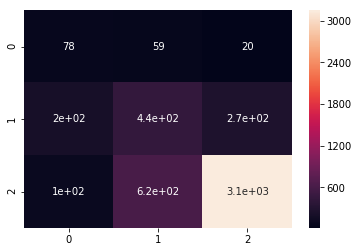

In [43]:
(XGBOOST_MODEL_VALIDATION_PROBABILITIES,
 XGBOOST_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_xgboost_model,
        predict_with_sklearn_estimator,
        # Determined by Grid Search, above
        train_param_grid_optimal={
            'colsample_bytree': [1.0],
            'gamma': [1.5],
            'max_depth': [5],
            'min_child_weight': [1],
            'n_estimators': [200],
            'subsample': [0.6]
        }
    )
)

In [44]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        XGBOOST_MODEL_TEST_PROBABILITIES,
    ),
    'xgboost_submissions.csv'
)

## 3.3 Random Forest

Random forest is basically an ensemble of lots of decision trees and we average out the results from each tree.

In [45]:
def train_rf_model(data_info,
                   featurized_train_data,
                   featurized_validation_data,
                   train_labels,
                   validation_labels,
                   train_param_grid_optimal=None):
    pipeline = basic_random_forest_pipeline(featurized_train_data,
                                            train_labels,
                                            # Determined by Grid Search, above
                                            param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    6.5s finished
Best parameters {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.70      0.82      4936

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.33      0.23      0.27      4936
weighted avg       1.00      0.70      0.82      4936

Logistic loss 0.75158


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

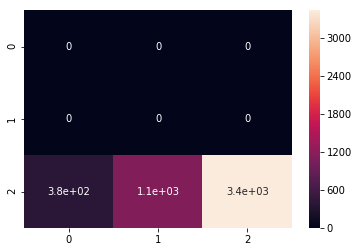

In [46]:
(RF_MODEL_VALIDATION_PROBABILITIES,
 RF_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_rf_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'bootstrap': [False],
            'max_depth': [5],
            'min_samples_leaf': [1],
            'n_estimators': [100]
        }
    )
)

## 3.4 Adaboost

In this approach, we combine several "weak" classifiers into a "strong" classifier. It is actually a meta-learning technique, though we use a decision tree as the base model.

In [47]:
def train_adaboost_model(data_info,
                         featurized_train_data,
                         featurized_validation_data,
                         train_labels,
                         validation_labels,
                         train_param_grid_optimal=None):
    pipeline = basic_adaboost_pipeline(featurized_train_data,
                                       train_labels,
                                       # Determined by Grid Search, above
                                       param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   16.0s finished
Best parameters {'learning_rate': 0.1, 'n_estimators': 100}
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
77,Amazing 2 bedroom apartment in beautif...
147,This Newly Renovated 3BR Apartment Features Hi...
312,This newly renovated apartment has beautiful h...


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
73,"This beautiful newly renovated 1 bedroom, 1 ba..."
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...
86,Gut renovated 2 rooms studio apartment locate...


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description
0,"Location is key! Stainless steel appliances, g..."
197,EMAIL ONLY...DUE TO HIGH DEMAND...NO CALLS PLE...
198,1 MONTH FREE RENT!!! Nice renovated 3 bedroom ...
233,** No Broker Fee and 1 Month Free! ** Advertis...
317,"The Harrison offers studios, 1 bedroom and two..."


Label was 1, classified as 2


,description
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...
20,This classic Lower East Side 1BR comes at a pr...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description
59,NO BROKERS FEE! This apartment is located in a...
125,Beautiful Three Bedroom Apartment Loca...
720,This stunning recently renovated studio apartm...
825,Kings &amp; Queens NO FEE Apartments are locat...
1177,Kings &amp; Queens NO FEE Apartments are locat...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.07      0.45      0.13       186
           2       0.99      0.72      0.83      4750

   micro avg       0.71      0.71      0.71      4936
   macro avg       0.35      0.39      0.32      4936
weighted avg       0.96      0.71      0.80      4936

Logistic loss 1.00533


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

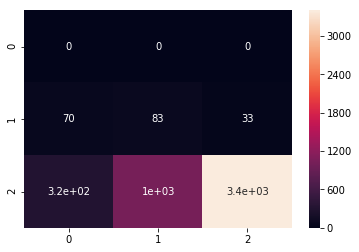

In [48]:
(ADABOOST_MODEL_VALIDATION_PROBABILITIES,
 ADABOOST_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_adaboost_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'learning_rate': [0.1],
            'n_estimators': [100]
        }
    )
)

## 3.4 ExtraTrees

Extratrees is also another ensembling based model. It stands for "Extremely Randomized Trees". Its main property is that it reduces variance for a small incrase in bias.

In [49]:
def train_extratrees_model(data_info,
                           featurized_train_data,
                           featurized_validation_data,
                           train_labels,
                           validation_labels,
                           train_param_grid_optimal=None):
    pipeline = basic_extratrees_pipeline(featurized_train_data,
                                         train_labels,
                                         # Determined by Grid Search, above
                                         param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.2s finished
Best parameters {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.70      0.82      4936

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.33      0.23      0.27      4936
weighted avg       1.00      0.70      0.82      4936

Logistic loss 0.75924


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

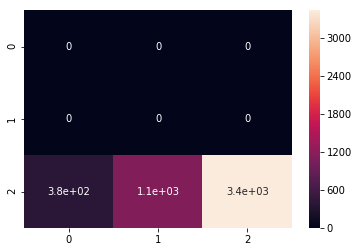

In [50]:
(EXTRATREES_MODEL_VALIDATION_PROBABILITIES,
 EXTRATREES_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_extratrees_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'bootstrap': [False],
            'max_depth': [5],
            'min_samples_leaf': [1],
            'n_estimators': [200]
        }
    )
)

### 3.5 SVC

With Support Vector Machines we can make use of kernel functions in order to try and have non-linear fits on our data. For instance, below we use the radial-basis-function kernel, though it doesn't perform as well as we would like.

In [51]:
def train_svc_model(data_info,
                    featurized_train_data,
                    featurized_validation_data,
                    train_labels,
                    validation_labels,
                    train_param_grid_optimal=None):
    pipeline = basic_svc_pipeline(featurized_train_data,
                                  train_labels,
                                  # Determined by Grid Search, above
                                  param_grid_optimal=train_param_grid_optimal)
    pipeline.fit(featurized_train_data, train_labels)
    print("Best parameters {}".format(pipeline.best_params_))
    return pipeline

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 36.8min
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed: 37.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed: 37.8min finished
Best parameters {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description
835,"Modern renovations throughout, with flowing sp..."


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description
1073,This renovated gorgeous apartment with spaciou...
2684,This renovated gorgeous apartment with spaciou...
4655,This renovated gorgeous apartment with spaciou...
4875,"Modern renovations throughout, with flowing sp..."


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description
1656,This renovated gorgeous apartment with spaciou...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.67      0.01         6
           2       1.00      0.70      0.82      4930

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.33      0.45      0.28      4936
weighted avg       1.00      0.70      0.82      4936

Logistic loss 0.65685


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

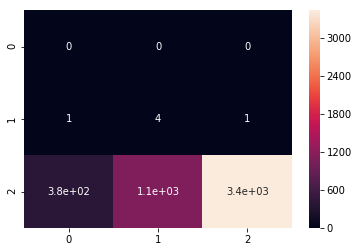

In [52]:
(SVC_MODEL_VALIDATION_PROBABILITIES,
 SVC_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_for_tabular_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_svc_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'C': [1.0],
            'gamma': ['scale'],
            'kernel': ['rbf']
        }
    )
)

### 3.6 Neural Net (Text Classification) Approaches

Here we leverage the actual text in the "description" field to try and do the classification, both independently and on top of the tabular data using Neural Nets with PyTorch.

Before we do that, it will be convenient to split our
data into continuous and categorical sections (as the categorical
sections will be put through independent embeddings in each
model) and tensorify some of our data, so lets do that now.

Note that the continuous data needs to be scaled to have zero mean
and unit variance - this prevents saturation of activation units
in the upper classification layers.

In [54]:
((TRAIN_FEATURES_CONTINUOUS,
  TRAIN_FEATURES_CATEGORICAL),
 (VALIDATION_FEATURES_CONTINUOUS,
  VALIDATION_FEATURES_CATEGORICAL),
 (TEST_FEATURES_CONTINUOUS,
  TEST_FEATURES_CATEGORICAL)) = rescale_features_and_split_into_continuous_and_categorical(CATEGORICAL_FEATURES,
                                                                                           FEATURES_TRAIN_DATAFRAME,
                                                                                           FEATURES_VALIDATION_DATAFRAME,
                                                                                           FEATURES_TEST_DATAFRAME)

Now we convert the labels into tensors, but we only put the labels
on the GPU (not the rest of the data, we'd run out of memory). Skorch
will conveniently put each batch on the GPU for us, so we don't need to
worry about that.

In [55]:
TRAIN_LABELS_TENSOR = torch.tensor(TRAIN_LABELS.values).long()
VALIDATION_LABELS_TENSOR = torch.tensor(VALIDATION_LABELS.values).long()

In [56]:
TRAIN_FEATURES_CONTINUOUS_TENSOR = torch.tensor(TRAIN_FEATURES_CONTINUOUS).float()
TRAIN_FEATURES_CATEGORICAL_TENSOR = torch.tensor(TRAIN_FEATURES_CATEGORICAL).long()

In [57]:
VALIDATION_FEATURES_CONTINUOUS_TENSOR = torch.tensor(VALIDATION_FEATURES_CONTINUOUS).float()
VALIDATION_FEATURES_CATEGORICAL_TENSOR = torch.tensor(VALIDATION_FEATURES_CATEGORICAL).long()

In [58]:
TEST_FEATURES_CONTINUOUS_TENSOR = torch.tensor(TEST_FEATURES_CONTINUOUS).float()
TEST_FEATURES_CATEGORICAL_TENSOR = torch.tensor(TEST_FEATURES_CATEGORICAL).long()

#### 3.6.1 Simple RNN/LSTM

Before we start putting our data into the RNN, lets tokenize our descriptions. In order to do this we'll be using fastai's Tokenizer class. We can preview the result of tokenization below

In [59]:
preview_tokenization(TRAIN_DATAFRAME["description"][:10])

,Original,Tokenized
0,Enjoy this spacious 1 bedroom with unobstructe...,xxmaj enjoy this spacious 1 bedroom with unobs...
1,Lovely and spacious 2 Bed / 1 Bath apartment w...,xxmaj lovely and spacious 2 xxmaj bed / 1 xxma...
2,Luxury Doorman Building- Full Service- Valet- ...,xxmaj luxury xxmaj doorman xxmaj building- xxm...
3,"Perfect for roommates, Prime area, Pri...","xxmaj perfect for roommates , xxmaj prime ar..."
4,"This is a great, renovated 3 bedroom apartment...","xxmaj this is a great , renovated 3 bedroom ap..."
5,Priced to move! Floor-Thru TRUE 3 Bedroom in t...,xxmaj priced to move ! xxmaj floor - xxmaj thr...
6,*****AVAILABLE NOW****EXCELLENT SHARE**MUST SE...,xxrep 5 * xxup available xxup now xxrep 4 * ...
7,Be the first to live in this spacious one bedr...,xxmaj be the first to live in this spacious on...
8,Beautiful 1BR in the Murray Hill. 750 Sqft sp...,xxmaj beautiful xxup 1br in the xxmaj murray x...
9,Lets see this awesome 4br apartment right in W...,xxmaj lets see this awesome 4br apartment righ...


Now we need to encode our tokens as **padded** sequences of integers such that we have a matrix of length [n $\times$ max_len].

To start our with, PyTorch takes one-hot encoded data as a single array of integers, where each integer specifies the index into some sparse vector where a $1$ will be set. Of course, if you have such sparse vectors, you can save a lot of time on the multiplication by just picking the right dimension and ignoring all the zero ones, which is exactly what happens internally.

The reason why we need padding is for computational efficiency reasons - we want to push a large batch of sentences on to the GPU for parallel computation all, but in order for this to work we need to pass the GPU a big square matrix. This means that the matrix will have at least as many columns as the maximum number of tokens in a sentence, where every other shorter sentence will be padded by a special "<PAD>" token. We also keep the length of every unpadded sentence in a separate vector - we'll see later that this is used by torch as an optimization to prevent the RNN from running over all the padding tokens within a batch.

In [60]:
preview_encoded_sentences(TRAIN_DATAFRAME["description"][:10])

,Original,Encoded,Length
0,Enjoy this spacious 1 bedroom with unobstructe...,"6, 537, 47, 14, 538, 96, 538, 360, 537, 39, 14...",387
1,Lovely and spacious 2 Bed / 1 Bath apartment w...,"536, 326, 536, 194, 536, 138, 536, 248, 536, 4...",183
2,Luxury Doorman Building- Full Service- Valet- ...,"536, 325, 80, 450, 31, 536, 113, 22, 24, 536, ...",176
3,"Perfect for roommates, Prime area, Pri...","536, 208, 485, 450, 24, 114, 533, 510, 165, 51...",156
4,"This is a great, renovated 3 bedroom apartment...","536, 395, 490, 347, 7, 536, 239, 16, 536, 488,...",145
5,Priced to move! Floor-Thru TRUE 3 Bedroom in t...,"6, 536, 383, 243, 420, 15, 536, 396, 88, 15, 5...",134
6,*****AVAILABLE NOW****EXCELLENT SHARE**MUST SE...,"536, 110, 483, 232, 490, 312, 277, 485, 450, 3...",129
7,Be the first to live in this spacious one bedr...,"536, 306, 424, 485, 100, 45, 82, 415, 277, 536...",126
8,Beautiful 1BR in the Murray Hill. 750 Sqft sp...,"536, 485, 283, 67, 258, 15, 410, 36, 114, 82, ...",112
9,Lets see this awesome 4br apartment right in W...,"536, 112, 538, 30, 277, 483, 536, 348, 536, 26...",84


Here we roll our own simple LSTM classifier using Skorch and PyTorch.

The `SimpleRNNPredictor` model just takes a batch of encoded word-encoded
sentences and runs them through a Bi-LSTM, then has a fully connected
layer sitting on top of the final "hidden" output of the LSTM (think
of the hidden state being passed through the LSTM along with each encoded input for the entire sentence all the way up to the sentence length). Then we just predict the class based on the final hidden state.

What Skorch does here is it implements the training loop, allows us
to add "hooks" (for instance, scoring on every epoch, a progress bar,
checkpointing so that we only keep our best model by validation loss,
cyclic learning rate scheduling and learning rate annealing (we reduce the learning rate if our validation loss is not going down)). It also wraps the model in an sklearn estimator-like API, so we can use it just like any other estimator.

Note that the NoToTensorInLossClassifier implements a few fixes on top
of NeuralNetClassifier - in particular `predict_proba` takes the exponent of the returned probabilities since we return log-softmax probabilities that get passed to `NLLLoss`.

In [61]:
def featurize_for_rnn_language_model(*dataframes):
    data_info, model_datasets = featurize_sequences_from_dataframe(*dataframes)
    return data_info, model_datasets


def train_rnn_model(data_info,
                    featurized_train_data,
                    featurized_validation_data,
                    train_labels,
                    validation_labels,
                    train_param_grid_optimal=None):
    word_to_one_hot, one_hot_to_word = data_info
    train_word_description_sequences, train_word_sequences_lengths = featurized_train_data
    model = NoToTensorInLossClassifier(
        SimpleRNNPredictor,
        module__encoder_dimension=100, # Number of encoder features
        module__hidden_dimension=50, # Number of hidden features
        module__dictionary_dimension=len(one_hot_to_word), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.1,
        lr=1e-2,
        batch_size=256,
        optimizer=optim.Adam,
        max_epochs=4,
        module__layers=2,
        train_split=simple_train_test_split_without_shuffle_func(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='rnn_lang_checkpoint'),
            TrainEndCheckpoint(dirname='rnn_lang_checkpoint',
                               fn_prefix='rnn_train_end_')
        ]
    )
    model.fit((train_word_description_sequences,
               train_word_sequences_lengths),
              maybe_cuda(train_labels))
    
    return model

Training NoToTensorInLossClassifier
 - Module
   - module:
   - module__encoder_dimension:
   - module__hidden_dimension:
   - module__dictionary_dimension:
   - module__output_dimension:
   - module__dropout:
   - module__layers:
 - Optimizer
   - optimizer:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 0.01
    - max_epochs: 4
    - batch_size: 256
    - verbose: 1
    - device: cuda


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6859        0.8489       0.6859        0.8277     +  71.4481


      2      0.6940        0.8082       0.6940        0.8191     +  71.4263


      3      0.6934        0.8009       0.6934        0.8424        71.4447


      4      0.6904        0.7948       0.6904        0.8471        71.0584
Loading parameters from checkpoint 1
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description
362,This is a LARGE STUDIO with walking closet apa...
1543,This apartment is in the heart of the financia...
2893,"Williamsburg 2-Bedroom, Montrose L Train, $240..."
3169,Intriguing studio unit along the East side of ...
4198,<center><strong> </strong><br><br> <strong><u>...


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description
323,This beautiful apartment has granite kitchen w...
616,Great Upper West Side location. Near Columbia ...
624,This spacious sunny 2 BEDROOM has a full kitch...
1045,Renovated studio in the west village.
1105,Spacious 2 bedroom 2 bath apartment with floor...


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description
36,Apartment: Amazing 1 bedroom unit featuring a ...
96,THIS NEIGHBORHOOD IS FILLED WITH MOVE THEATERS...
108,NO FEE****NO FEE****NO FEE****OFF 3RD AV***OFF...
358,--NO FEE-- 1 BEDROOM - CONVERTIBLE 2. FULLY RE...
365,NO BROKER FEE!!! & 1 Month Free* Advertised re...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.24      0.02        58
           2       0.99      0.70      0.82      4878

   micro avg       0.69      0.69      0.69      4936
   macro avg       0.33      0.31      0.28      4936
weighted avg       0.98      0.69      0.81      4936

Logistic loss 0.83857


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

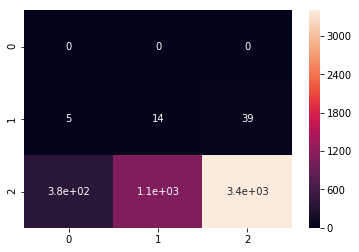

In [62]:
(SIMPLE_RNN_MODEL_VALIDATION_PROBABILITIES,
 SIMPLE_RNN_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_for_rnn_language_model,
        train_rnn_model,
        predict_with_sklearn_estimator
    )
)

In [63]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        SIMPLE_RNN_MODEL_TEST_PROBABILITIES,
    ),
    'simple_rnn_model_submissions.csv'
)

In [64]:
def splice_into_datasets(datasets, append):
    return tuple(list(d) + list(a) for d, a in zip(datasets, append))

def featurize_for_rnn_tabular_model(*dataframes):
    data_info, model_datasets = featurize_sequences_from_dataframe(*dataframes)
    # Need to wrap each dataset in outer list so that splicing works correctly
    return data_info, splice_into_datasets(model_datasets,
                                           ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                             TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                            (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                             VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                            (TEST_FEATURES_CONTINUOUS_TENSOR,
                                             TEST_FEATURES_CATEGORICAL_TENSOR )))


def train_rnn_tabular_model(data_info,
                            featurized_train_data,
                            featurized_validation_data,
                            train_labels,
                            validation_labels,
                            train_param_grid_optimal=None):
    word_to_one_hot, one_hot_to_word = data_info
    _, _, train_continuous, train_categorical = featurized_train_data
    model = NoToTensorInLossClassifier(
        SimpleRNNTabularDataPredictor,
        module__encoder_dimension=100, # Number of encoder features
        module__hidden_dimension=50, # Number of hidden features
        module__dictionary_dimension=len(one_hot_to_word), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.1,
        module__continuous_features_dimension=train_continuous.shape[1],
        module__categorical_feature_embedding_dimensions=[
            (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
        ],
        lr=1e-2,
        batch_size=256,
        optimizer=optim.Adam,
        max_epochs=4,
        module__layers=2,
        train_split=simple_train_test_split_without_shuffle_func(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='rnn_lang_checkpoint'),
            TrainEndCheckpoint(dirname='rnn_lang_checkpoint',
                               fn_prefix='rnn_train_end_')
        ]
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    
    return model

Training NoToTensorInLossClassifier
 - Module
   - module:
   - module__encoder_dimension:
   - module__hidden_dimension:
   - module__dictionary_dimension:
   - module__output_dimension:
   - module__dropout:
   - module__continuous_features_dimension:
   - module__categorical_feature_embedding_dimensions:
   - module__layers:
 - Optimizer
   - optimizer:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 0.01
    - max_epochs: 4
    - batch_size: 256
    - verbose: 1
    - device: cuda


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6931        0.8141       0.6931        0.7121     +  69.9172


      2      0.6941        0.6453       0.6941        0.6782     +  72.7762


      3      0.6785        0.6184       0.6785        0.7055        72.0307


      4      0.6985        0.6042       0.6985        0.6825        69.3119
Loading parameters from checkpoint 1
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 0, classified as 2


,description
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...
107,No Fee!\rFurnished or Unfurnished\rAll apartme...
115,True 2 bedroom apartment on 3rd floor of class...
143,Located in a classic walk-up apartment buildin...
177,NO FEE/FLEX1BED/GRAND CENTRAL/WD/24 DM/BRAND-N...


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
32,Queen Size BedroomsEbony Hardwood FloorsRecess...
46,"29TH! PRIME KIPS BAY, HIGH FLOOR, LARGE FLEX 2..."
48,NO FEE!!! THIS IS A MUST SEE NEWLY RENOVATED O...


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...
20,This classic Lower East Side 1BR comes at a pr...
27,Featuring a spacaious One Bedroom unit in a we...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description
15,Apartment Features:\r-Bedroom Fits Queen Sized...
35,<center><strong><font color=#006600>- <u>NO FE...
42,[ The Apartment ] - Pristine PRE-WAR GEM locat...
49,Fresh newly renovated apartment that features ...
51,THIS IS THE BEST PRICED TRUE 2 BEDROOM UNIT IN...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.46      0.40      0.43      1269
           2       0.85      0.79      0.82      3667

   micro avg       0.69      0.69      0.69      4936
   macro avg       0.44      0.40      0.42      4936
weighted avg       0.75      0.69      0.72      4936

Logistic loss 0.68546


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

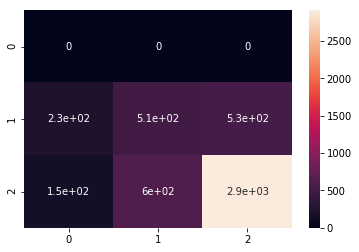

In [65]:
(SIMPLE_RNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 SIMPLE_RNN_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_for_rnn_tabular_model,
        train_rnn_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [66]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        SIMPLE_RNN_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'simple_rnn_model_tabular_data_submissions.csv'
)

### 3.6.1 FastText

A key concept here is that we compute the bigrams of a sentence and then apply them to the end of the sentence.

Then we just put the whole thing through linear layers after average pooling, the average pooling takes into account the big-grams.

In [67]:
def featurize_dataframe_sequences_for_fasttext(*dataframes):
    sequences_lists = tokenize_sequences(
        *tuple(list(df['clean_description']) for df in dataframes)
    )

    text = torchtext_create_text_vocab(*sequences_lists,
                                       vectors='glove.6B.100d')
    
    return text, torchtext_process_texts(*postprocess_sequences(
        *sequences_lists,
        postprocessing=generate_bigrams
    ), text=text)


def train_fasttext_model(data_info,
                         featurized_train_data,
                         featurized_validation_data,
                         train_labels,
                         validation_labels,
                         train_param_grid_optimal=None):
    embedding_dim = 100
    model = NoToTensorInLossClassifier(
        FastText,
        lr=0.001,
        batch_size=256,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
            TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                               fn_prefix='fasttext_train_end_')
        ],
        max_epochs=6,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

02/04/2019 10:56:36 - INFO - torchtext.vocab -   Loading vectors from .vector_cache/glove.6B.100d.txt.pt


Training NoToTensorInLossClassifier
 - Module
   - module:
   - module__encoder_dimension:
   - module__dictionary_dimension:
   - module__output_dimension:
   - module__dropout:
   - module__pretrained:
 - Optimizer
   - optimizer:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 0.001
    - max_epochs: 6
    - batch_size: 256
    - verbose: 1
    - device: cuda


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.7054        0.7883       0.7054        0.7575     +  22.8884


      2      0.7081        0.7639       0.7081        0.7489     +  22.9541


      3      0.7051        0.7444       0.7051        0.7497        22.8686


      4      0.7045        0.7336       0.7045        0.7311     +  22.8641


      5      0.7042        0.7203       0.7042        0.7265     +  22.8621


      6      0.7063        0.7102       0.7063        0.7198     +  22.9052
Loading parameters from checkpoint 5
Label was 0, classified as 0


,description
1227,31ST/PARK AVE !! Large RENO Studio w/ ELEVATOR...


Label was 0, classified as 1


,description
39,Live in the heart of SoHo for a fraction of th...
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
77,Amazing 2 bedroom apartment in beautif...
115,True 2 bedroom apartment on 3rd floor of class...


Label was 0, classified as 2


,description
54,
73,"This beautiful newly renovated 1 bedroom, 1 ba..."
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...
86,Gut renovated 2 rooms studio apartment locate...
107,No Fee!\rFurnished or Unfurnished\rAll apartme...


Label was 1, classified as 0


,description
176,ANALYZE THIS! Take a quick preview of this MAG...
1976,"Location, Location, Location!!! If the perfect..."
2601,GREAT SIZE STUDIO in the heart of Greenwich Vi...


Label was 1, classified as 1


,description
3,This is a huge convertible 3 bedroom 2 bathroo...
20,This classic Lower East Side 1BR comes at a pr...
41,::: Apartment Features :::* Renovated 4 Bedroo...
46,"29TH! PRIME KIPS BAY, HIGH FLOOR, LARGE FLEX 2..."
102,***AMAZING DEAL!***EASY APPROVAL!***STEPS FROM...


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...
27,Featuring a spacaious One Bedroom unit in a we...


Label was 2, classified as 0


,description
1702,Prime Union Square .. HUGE .. 950 sqft .. JR-4...
3978,"Steps from 4,5,6 lineone stop from Grand Centr..."


Label was 2, classified as 1


,description
8,Unbeatable location in this Murray Hill Flex 3...
35,<center><strong><font color=#006600>- <u>NO FE...
43,Live in this beautiful LARGE 2 bedroom / 2 bat...
51,THIS IS THE BEST PRICED TRUE 2 BEDROOM UNIT IN...
55,***NO FEE*** HUGE FLEX 4 BEDROOM 2 BATH ***LUX...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.17      0.01         6
           1       0.20      0.39      0.26       577
           2       0.93      0.73      0.82      4353

   micro avg       0.69      0.69      0.69      4936
   macro avg       0.38      0.43      0.36      4936
weighted avg       0.84      0.69      0.75      4936

Logistic loss 0.75707


None

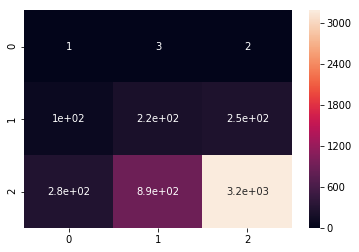

In [68]:
(FASTTEXT_MODEL_VALIDATION_PROBABILITIES,
 FASTTEXT_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_dataframe_sequences_for_fasttext,
        train_fasttext_model,
        predict_with_sklearn_estimator
    )
)

In [69]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        FASTTEXT_MODEL_TEST_PROBABILITIES,
    ),
    'fasttext_model_submissions.csv'
)

In [70]:
def featurize_for_fasttext_tabular_model(*dataframes):
    data_info, model_datasets = featurize_dataframe_sequences_for_fasttext(*dataframes)
    # Need to wrap each dataset in outer list so that splicing works correctly
    return data_info, splice_into_datasets(tuple([x] for x in model_datasets),
                                           ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                             TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                            (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                             VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                            (TEST_FEATURES_CONTINUOUS_TENSOR,
                                             TEST_FEATURES_CATEGORICAL_TENSOR)))


def train_fasttext_tabular_model(data_info,
                                 featurized_train_data,
                                 featurized_validation_data,
                                 train_labels,
                                 validation_labels,
                                 train_param_grid_optimal=None):
    embedding_dim = 100
    _, train_features_continuous, _ = featurized_train_data
    model = NoToTensorInLossClassifier(
        FastTextWithTabularData,
        lr=0.001,
        batch_size=256,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
            TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                               fn_prefix='fasttext_train_end_')
        ],
        max_epochs=6,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors,
        module__continuous_features_dimension=train_features_continuous.shape[1],
        module__categorical_feature_embedding_dimensions=[
            (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
        ],
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

02/04/2019 10:59:56 - INFO - torchtext.vocab -   Loading vectors from .vector_cache/glove.6B.100d.txt.pt


Training NoToTensorInLossClassifier
 - Module
   - module:
   - module__encoder_dimension:
   - module__dictionary_dimension:
   - module__output_dimension:
   - module__dropout:
   - module__pretrained:
   - module__continuous_features_dimension:
   - module__categorical_feature_embedding_dimensions:
 - Optimizer
   - optimizer:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 0.001
    - max_epochs: 6
    - batch_size: 256
    - verbose: 1
    - device: cuda


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6894        0.8962       0.6894        0.7539     +  22.7503


      2      0.6475        0.8451       0.6475        1.2731        23.5381


      3      0.6775        0.8302       0.6775        1.1883        23.5085


      4      0.6634        0.7744       0.6634        1.2849        23.3863


      5      0.6731        0.7249       0.6731        1.0820        23.3748


      6      0.6705        0.6225       0.6705        1.0422        23.3864
Loading parameters from checkpoint 0
Label was 0, classified as 0


,description
134,This apartment is situated in a luxury elevato...
149,NO FEEThis Colossal Luxury Building is situate...
291,
297,Renovated three bedroom in a Prime Midtown Eas...
574,Call Brad Lassiter &quot;The Agent Who Cares&q...


Label was 0, classified as 1


,description
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
77,Amazing 2 bedroom apartment in beautif...
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."
86,Gut renovated 2 rooms studio apartment locate...
107,No Fee!\rFurnished or Unfurnished\rAll apartme...
115,True 2 bedroom apartment on 3rd floor of class...


Label was 1, classified as 0


,description
20,This classic Lower East Side 1BR comes at a pr...
46,"29TH! PRIME KIPS BAY, HIGH FLOOR, LARGE FLEX 2..."
104,*** AAA Luxury Building in Prime Midtown West...
151,Midtown Luxury at it's finest! -With 24 hour d...
197,EMAIL ONLY...DUE TO HIGH DEMAND...NO CALLS PLE...


Label was 1, classified as 1


,description
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
13,Call / Text / Email Afrim or Philip today to s...
27,Featuring a spacaious One Bedroom unit in a we...
38,"Newly renovated with Dishwasher, washer/dryer,..."


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
32,Queen Size BedroomsEbony Hardwood FloorsRecess...
48,NO FEE!!! THIS IS A MUST SEE NEWLY RENOVATED O...
56,This beautifully renovated one bedroom comes w...


Label was 2, classified as 0


,description
35,<center><strong><font color=#006600>- <u>NO FE...
355,85TH/ 3 AVE!! BEAUTIFUL FLEX 2 BED 750 SQF IN...
537,This apartment is spacious and bright with bea...
546,"This spacious studio features high ceilings, l..."
608,Prime UES on 86th!! Large RENO Studio w/ Balco...


Label was 2, classified as 1


,description
16,Sublet available at Full service Building for ...
34,MAKE YOUR LIFE EASIER. STICK WITH ONE BROKER. ...
42,[ The Apartment ] - Pristine PRE-WAR GEM locat...
43,Live in this beautiful LARGE 2 bedroom / 2 bat...
50,"2 Bedroom ApartmentNew to Williamsburg, 50 Nor..."


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.17      0.27      0.21       242
           1       0.33      0.38      0.36       974
           2       0.84      0.78      0.81      3720

   micro avg       0.68      0.68      0.68      4936
   macro avg       0.45      0.48      0.46      4936
weighted avg       0.71      0.68      0.69      4936

Logistic loss 0.78963


None

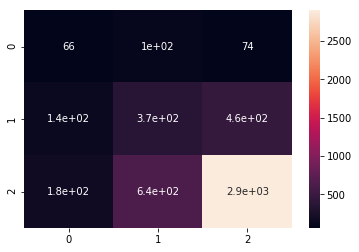

In [71]:
(FASTTEXT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 FASTTEXT_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_for_fasttext_tabular_model,
        train_fasttext_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [72]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        FASTTEXT_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'fasttext_tabular_model_submissions.csv'
)

### 3.6.3 TextCNN
Here we use a convolutional neural network on the text.

We kind of have to think of text like an "image". The horizontal
dimension is just each sentence (of variable length, but they all have
padding at the end). Then on the vertical axis, we have the word vectors
and we move our window across. Idea here is that similar to images, the
order between words and between word vector components probably matters,
so we take into account conceptual space and sentence space in the text
image domain.

In [73]:
def featurize_dataframe_sequences_for_textcnn(*dataframes):
    sequences_lists = tokenize_sequences(
        *tuple(list(df['clean_description']) for df in dataframes)
    )

    text = torchtext_create_text_vocab(*sequences_lists,
                                       vectors='glove.6B.100d')
    
    return text, tuple(text.process(sl).transpose(0, 1) for sl in sequences_lists)

def train_textcnn_model(data_info,
                        featurized_train_data,
                        featurized_validation_data,
                        train_labels,
                        validation_labels,
                        train_param_grid_optimal=None):
    embedding_dim = 100
    model = NoToTensorInLossClassifier(
        TextCNN,
        lr=0.001,
        batch_size=64,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='textcnn_checkpoint'),
            TrainEndCheckpoint(dirname='textcnn_tabular_checkpoint',
                               fn_prefix='textcnn_train_end_')
        ],
        max_epochs=10,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__n_filters=10,
        module__filter_sizes=(3, 4, 5),
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

02/04/2019 11:03:18 - INFO - torchtext.vocab -   Loading vectors from .vector_cache/glove.6B.100d.txt.pt


Training NoToTensorInLossClassifier
 - Module
   - module:
   - module__encoder_dimension:
   - module__dictionary_dimension:
   - module__output_dimension:
   - module__n_filters:
   - module__filter_sizes:
   - module__dropout:
   - module__pretrained:
 - Optimizer
   - optimizer:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 0.001
    - max_epochs: 10
    - batch_size: 64
    - verbose: 1
    - device: cuda


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.7084        1.0555       0.7084        1.0810     +  19.8076


      2      0.7071        1.5457       0.7071        1.2511        19.6401


      3      0.7094        1.1930       0.7094        0.9425     +  19.6478


      4      0.7117        0.9872       0.7117        0.9194     +  19.6989


      5      0.7107        1.0661       0.7107        0.9998        19.7282


      6      0.7117        0.9938       0.7117        0.8947     +  19.8810


      7      0.7118        0.8561       0.7118        0.8078     +  19.7800


      8      0.7118        0.8276       0.7118        0.7968     +  19.6470


      9      0.7118        0.7846       0.7118        0.7948     +  19.9314


     10      0.7118        0.7727       0.7118        0.7945     +  19.6361
Loading parameters from checkpoint 9
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description


Label was 1, classified as 2


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.70      0.82      4936

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.33      0.23      0.27      4936
weighted avg       1.00      0.70      0.82      4936

Logistic loss 0.81007


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

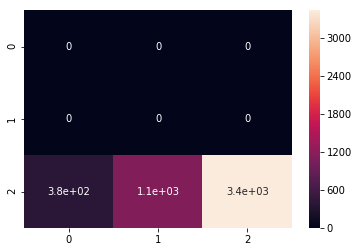

In [74]:
(TEXTCNN_MODEL_VALIDATION_PROBABILITIES,
 TEXTCNN_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_dataframe_sequences_for_textcnn,
        train_textcnn_model,
        predict_with_sklearn_estimator
    )
)

In [75]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEXTCNN_MODEL_TEST_PROBABILITIES,
    ),
    'textcnn_model_submissions.csv'
)

In [76]:
def featurize_dataframes_for_textcnn_tabular_model(*dataframes):
    data_info, model_datasets = featurize_dataframe_sequences_for_textcnn(*dataframes)
    return data_info, splice_into_datasets(tuple([x] for x in model_datasets),
                                           ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                             TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                            (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                             VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                            (TEST_FEATURES_CONTINUOUS_TENSOR,
                                             TEST_FEATURES_CATEGORICAL_TENSOR)))

def train_textcnn_tabular_model(data_info,
                                featurized_train_data,
                                featurized_validation_data,
                                train_labels,
                                validation_labels,
                                train_param_grid_optimal=None):
    embedding_dim = 100
    _, train_features_continuous, _ = featurized_train_data
    model = NoToTensorInLossClassifier(
        TextCNNWithTabularData,
        lr=0.001,
        batch_size=256,
        optimizer=optim.Adam,
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            LRAnnealing(),
            LRScheduler(),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='fasttext_checkpoint'),
            TrainEndCheckpoint(dirname='fasttext_tabular_checkpoint',
                               fn_prefix='fasttext_train_end_')
        ],
        max_epochs=10,
        train_split=shuffled_train_test_split_by_indices(0.3),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        module__encoder_dimension=embedding_dim, # Number of encoder features
        module__dictionary_dimension=len(data_info.vocab.itos), # Dictionary dimension
        module__output_dimension=3,
        module__n_filters=100,
        module__filter_sizes=(3, 4, 5),
        module__dropout=0.8,
        module__pretrained=data_info.vocab.vectors,
        module__continuous_features_dimension=train_features_continuous.shape[1],
        module__categorical_feature_embedding_dimensions=[
            (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
        ],
    )
    model.fit(featurized_train_data, maybe_cuda(train_labels))
    return model

02/04/2019 11:07:39 - INFO - torchtext.vocab -   Loading vectors from .vector_cache/glove.6B.100d.txt.pt


Training NoToTensorInLossClassifier
 - Module
   - module:
   - module__encoder_dimension:
   - module__dictionary_dimension:
   - module__output_dimension:
   - module__n_filters:
   - module__filter_sizes:
   - module__dropout:
   - module__pretrained:
   - module__continuous_features_dimension:
   - module__categorical_feature_embedding_dimensions:
 - Optimizer
   - optimizer:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 0.001
    - max_epochs: 10
    - batch_size: 256
    - verbose: 1
    - device: cuda


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      dur
-------  ----------  ------------  -----------  ------------  ----  -------
      1      0.6764        1.7918       0.6764        1.0592     +  21.7093


      2      0.6744        1.8306       0.6744        1.7608        20.9998


      3      0.6663        2.0718       0.6663        2.7205        22.3355


      4      0.6611        2.1353       0.6611        2.8573        22.1679


      5      0.6654        1.7631       0.6654        2.1106        22.3277


      6      0.6773        1.1712       0.6773        2.1831        22.4721


      7      0.6852        0.9716       0.6852        1.7941        22.3232


      8      0.6883        0.8543       0.6883        1.7078        22.3002


      9      0.7040        0.7245       0.7040        1.5495        21.3774


     10      0.7141        0.7094       0.7141        1.4762        20.9826
Loading parameters from checkpoint 0
Label was 0, classified as 0


,description
115,True 2 bedroom apartment on 3rd floor of class...
134,This apartment is situated in a luxury elevato...
291,
297,Renovated three bedroom in a Prime Midtown Eas...
344,StuyTown offers an unbeatable combination of c...


Label was 0, classified as 1


,description
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
77,Amazing 2 bedroom apartment in beautif...
107,No Fee!\rFurnished or Unfurnished\rAll apartme...


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."
85,THIS MURRAY HILL HIGH-RISE IS THE ESSENCE OF M...
86,Gut renovated 2 rooms studio apartment locate...
136,***HUGE FLEX 2 BEDROOM APT***LOCATION-LOCATION...


Label was 1, classified as 0


,description
74,THIS IS THE ONE THAT WILL END YOUR SEARCH!!! ...
102,***AMAZING DEAL!***EASY APPROVAL!***STEPS FROM...
120,located in the heart OF UPPER WEST SIDE 80'S A...
184,65TH/ CENTRAL PARK WEST!!!GORGEOUS FLEX 3 BED/...
186,HUGE Newly Renovated Studio featuring BRAND NE...


Label was 1, classified as 1


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
20,This classic Lower East Side 1BR comes at a pr...
27,Featuring a spacaious One Bedroom unit in a we...


Label was 1, classified as 2


,description
4,Renovated cozy studio on elevator building in ...
13,Call / Text / Email Afrim or Philip today to s...
32,Queen Size BedroomsEbony Hardwood FloorsRecess...
48,NO FEE!!! THIS IS A MUST SEE NEWLY RENOVATED O...
56,This beautifully renovated one bedroom comes w...


Label was 2, classified as 0


,description
51,THIS IS THE BEST PRICED TRUE 2 BEDROOM UNIT IN...
65,Awesomely Huge Studio apartment located on a p...
121,Perfect flex 2 under $3500. Available for imme...
137,Residence enjoy the Luxury High rise Full Serv...
157,This beautiful true 1 bed is located in the Fi...


Label was 2, classified as 1


,description
6,The building boasts a doorman and concierge to...
23,Flex 1 bedroom. \r\rYour new home features ove...
26,FANTASTIC studio apartment located on the Uppe...
35,<center><strong><font color=#006600>- <u>NO FE...
36,Apartment: Amazing 1 bedroom unit featuring a ...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...
8,Unbeatable location in this Murray Hill Flex 3...


              precision    recall  f1-score   support

           0       0.18      0.26      0.21       269
           1       0.32      0.39      0.35       928
           2       0.85      0.78      0.81      3739

   micro avg       0.68      0.68      0.68      4936
   macro avg       0.45      0.47      0.46      4936
weighted avg       0.71      0.68      0.69      4936

Logistic loss 0.93817


None

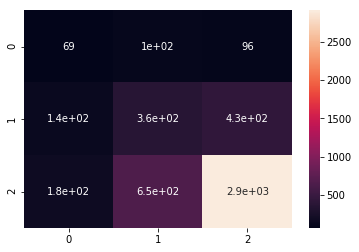

In [77]:
(TEXTCNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 TEXTCNN_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_dataframes_for_textcnn_tabular_model,
        train_textcnn_tabular_model,
        predict_with_sklearn_estimator
    )
)

In [78]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        TEXTCNN_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'textcnn_tabular_model_submissions.csv'
)

### 3.6.4 BERT

BERT is a big ol' attentional model.

We use the pretrained version of BERT (eg `bert-base-uncased`) and the
corresponding tokenizer - `bert_featurize_dataframe` reads from
`clean_description` in the dataframe and tokenizes sentences in the
same way that the pre-trained model was tokenized and should in principle
do the word vector mapping for us.

Essentially what we are doing here is fine-tuning the classification
layers of BERT.

In [90]:
gc_and_clear_caches(None)

In [96]:
def flatten_params(params):
    return {
        k: v[0] if isinstance(v, list) else v for k, v in params.items()
    }

In [97]:
BERT_MODEL = 'bert-base-uncased'


def featurize_bert_lang_features(*dataframes):
    return _, tuple(
        tuple(torch.stack(x) for x in zip(*features))
        for features in bert_featurize_data_frames(BERT_MODEL, *dataframes)
    )
        

def train_bert_lang_model(data_info,
                          featurized_train_data,
                          featurized_validation_data,
                          train_labels,
                          validation_labels,
                          train_param_grid_optimal=None):
    model = BertClassifier(
        module=create_bert_model(BERT_MODEL, 3),
        optimizer__warmup=WARMUP_PROPORTION,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        optimizer=BertAdam,
        lr=6e-5,
        len_train_data=int(len(featurized_train_data[0])),
        num_labels=3,
        batch_size=16,
        train_split=shuffled_train_test_split_by_indices(0.1),
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='bert_lang_checkpoint')
        ],
    )
    
    if not train_param_grid_optimal:
        # As sugested by Maksad, need to do a hyperparameter search
        # here to get good results.
        param_grid = {
            "batch_size": [16, 32],
            "lr": [6e-5, 3e-5, 3e-1, 2e-5],
            "max_epochs": [3, 4]
        }
        search = GridSearchCV(model,
                              param_grid,
                              cv=1,
                              refit=False,
                              scoring=make_scorer(log_loss,
                                                  greater_is_better=False,
                                                  needs_proba=True))
        search.fit(TensorTuple(featurized_train_data), train_labels)

        print('Best params {}'.format(search.best_params_))
        # Now re-fit the estimator manually, using the best params -
        # we do this manually since we need a different view over
        # the training data to make it work
        best = clone(search.estimator, safe=True).set_params(**search.best_params_)
        best.fit(featurized_train_data, train_labels)
        return best
    else:
        model = clone(model, safe=True).set_params(**flatten_params(train_param_grid_optimal))
        model.fit(featurized_train_data, train_labels)
        return model

02/04/2019 13:43:42 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
02/04/2019 13:46:09 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
02/04/2019 13:46:09 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tm

Training BertClassifier
 - Module
   - module:
 - Optimizer
   - optimizer:
   - optimizer__warmup:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 2e-05
    - max_epochs: 4
    - batch_size: 32
    - verbose: 1
    - device: cuda
    - num_labels: 3


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp       dur
-------  ----------  ------------  -----------  ------------  ----  --------
      1      0.2382        0.7985       0.2382        1.8094     +  587.5474


      2      0.7019        3.0932       0.7019        3.5981        565.5576


      3      0.2382        6.8321       0.2382        3.4069        578.7417


      4      0.7019       16.0541       0.7019       13.0731        587.9831
Loading parameters from checkpoint 0
Label was 0, classified as 0


,description


Label was 0, classified as 1


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 0, classified as 2


,description


Label was 1, classified as 0


,description


Label was 1, classified as 1


,description
0,"Location is key! Stainless steel appliances, g..."
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...


Label was 1, classified as 2


,description


Label was 2, classified as 0


,description


Label was 2, classified as 1


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


Label was 2, classified as 2


,description


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.23      0.37      4936
           2       0.00      0.00      0.00         0

   micro avg       0.23      0.23      0.23      4936
   macro avg       0.33      0.08      0.12      4936
weighted avg       1.00      0.23      0.37      4936

Logistic loss 1.87522


/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/u/77/spilsbt1/unix/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


None

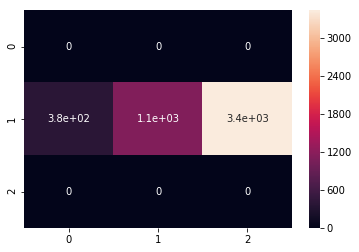

In [98]:
(BERT_LANG_MODEL_VALIDATION_PROBABILITIES,
 BERT_LANG_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS,
        VALIDATION_LABELS,
        featurize_bert_lang_features,
        train_bert_lang_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'lr': [2e-05],
            'max_epochs': [4],
            'batch_size': [32]
        }
    )
)

In [99]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        BERT_LANG_MODEL_TEST_PROBABILITIES,
    ),
    'bert_model_submissions.csv'
)

In [108]:
def featurize_bert_tabular_features(*dataframes):
    model_datasets = splice_into_datasets(tuple([x] for x in bert_featurize_data_frames(BERT_MODEL, *dataframes)),
                                          ((TRAIN_FEATURES_CONTINUOUS_TENSOR,
                                            TRAIN_FEATURES_CATEGORICAL_TENSOR),
                                           (VALIDATION_FEATURES_CONTINUOUS_TENSOR,
                                            VALIDATION_FEATURES_CATEGORICAL_TENSOR),
                                           (TEST_FEATURES_CONTINUOUS_TENSOR,
                                            TEST_FEATURES_CATEGORICAL_TENSOR)))
    return _, tuple(
        tuple(torch.stack(x) for x in zip(*[
            tuple(list(bert_features) + [continuous, categorical])
            for bert_features, continuous, categorical in zip(features,
                                                              continuous_tensor,
                                                              categorical_tensor)
        ]))
        for features, continuous_tensor, categorical_tensor in model_datasets
    )


def train_bert_tabular_model(data_info,
                             featurized_train_data,
                             featurized_validation_data,
                             train_labels,
                             validation_labels,
                             train_param_grid_optimal=None):
    batch_size = 16
    _, _, _, continuous_features, categorical_features = featurized_train_data
    model = BertClassifier(
        module=create_bert_model_with_tabular_features(
            BERT_MODEL,
            continuous_features.shape[1],
            [
                (CATEGORICAL_FEATURES[c], 80) for c in CATEGORICAL_FEATURES
            ],
            3
        ),
        len_train_data=int(len(featurized_train_data[0])),
        optimizer__warmup=WARMUP_PROPORTION,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        optimizer=BertAdam,
        num_labels=3,
        batch_size=batch_size,
        train_split=shuffled_train_test_split_by_indices(0.3),
        callbacks=[
            SummarizeParameters(),
            EpochScoring(scoring='accuracy'),
            ProgressBar(),
            CheckpointAndKeepBest(dirname='bert_lang_checkpoint')
        ],
    )
    
    if not train_param_grid_optimal:
        # As sugested by Maksad, need to do a hyperparameter search
        # here to get good results.
        param_grid = {
            "batch_size": [16, 32],
            "lr": [6e-5, 3e-5, 3e-5, 2e-5],
            "max_epochs": [3, 4]
        }
        search = GridSearchCV(model,
                              param_grid,
                              cv=2,
                              refit=False,
                              scoring=make_scorer(log_loss,
                                                  greater_is_better=False,
                                                  needs_proba=True))
        search.fit(TensorTuple(featurized_train_data), train_labels)

        print('Best params {}'.format(search.best_params_))
        # Now re-fit the estimator manually, using the best params -
        # we do this manually since we need a different view over
        # the training data to make it work
        best = clone(search.estimator, safe=True).set_params(**search.best_params_)
        best.fit(featurized_train_data, train_labels)
        return best
    else:
        model = clone(model, safe=True).set_params(**flatten_params(train_param_grid_optimal))
        model.fit(featurized_train_data, train_labels)
        return model

02/04/2019 19:03:36 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
02/04/2019 19:06:00 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
02/04/2019 19:06:00 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /u/77/spilsbt1/unix/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tm

Training BertClassifier
 - Module
   - module:
 - Optimizer
   - optimizer:
   - optimizer__warmup:
 - Criterion
   - criterion:
 - Remaining Paramters
    - lr: 2e-05
    - max_epochs: 4
    - batch_size: 32
    - verbose: 1
    - device: cuda
    - num_labels: 3


  epoch    accuracy    train_loss    valid_acc    valid_loss    cp       dur
-------  ----------  ------------  -----------  ------------  ----  --------
      1      0.7160        0.7224       0.7160        0.6738     +  490.3368


      2      0.6967        1.3660       0.6967        1.4915        489.0020


      3      0.5997        4.5901       0.5997        4.8172        478.8155


      4      0.6274       11.0678       0.6274       12.8930        487.0319
Loading parameters from checkpoint 0
Label was 0, classified as 0


,description
149,NO FEEThis Colossal Luxury Building is situate...
297,Renovated three bedroom in a Prime Midtown Eas...
707,BEAUTIFUL FLEX 3 WITH PRIVATE TERRACE. PASS TH...
835,"Modern renovations throughout, with flowing sp..."
1526,PRIME UNION SQUARE!! IRVING PLACE AND 17 ST!! ...


Label was 0, classified as 1


,description
147,This Newly Renovated 3BR Apartment Features Hi...
575,Sight to see. Come view this beautifully renov...
641,"ENJOY YOUR BEST SUMMER IN THE UPPER WEST SIDE,..."
749,This incredible bright and sunny flexible 2 be...
879,


Label was 0, classified as 2


,description
39,Live in the heart of SoHo for a fraction of th...
54,
61,NO FEE! NO FEE! NO FEE! Did we mention....NO ...
66,***AVAILABLE NOW***STEAL-DEAL****MUST SEE***HU...
73,"This beautiful newly renovated 1 bedroom, 1 ba..."


Label was 1, classified as 0


,description
46,"29TH! PRIME KIPS BAY, HIGH FLOOR, LARGE FLEX 2..."
420,<center><strong><font color=#006600>- <u>NO FE...
1113,NO FEE ..... AMAZING UNIT!! 2 BR 1 BA -- wash...
1118,"29TH/2ND PRIME KIPS BAY, HIGH FLOOR, LARGE 550..."
1217,Union Square Special! This apartment is situat...


Label was 1, classified as 1


,description
0,"Location is key! Stainless steel appliances, g..."
104,*** AAA Luxury Building in Prime Midtown West...
120,located in the heart OF UPPER WEST SIDE 80'S A...
199,Custom high end renovations in this fantastic ...
233,** No Broker Fee and 1 Month Free! ** Advertis...


Label was 1, classified as 2


,description
3,This is a huge convertible 3 bedroom 2 bathroo...
4,Renovated cozy studio on elevator building in ...
11,NET EFFECTIVE RENT $2750 On A 13 MO LEASE WITH...
13,Call / Text / Email Afrim or Philip today to s...
20,This classic Lower East Side 1BR comes at a pr...


Label was 2, classified as 0


,description
35,<center><strong><font color=#006600>- <u>NO FE...
1591,GIGANTIC TRUE 3 BED/ 2 BATH TRIPLEX WITH TERRA...
1656,This renovated gorgeous apartment with spaciou...
2297,"Budget friendly TWO bedrooms with one bath, th..."
3078,THE APARTMENT: STUNNING WEST Facing Studio apa...


Label was 2, classified as 1


,description
51,THIS IS THE BEST PRICED TRUE 2 BEDROOM UNIT IN...
124,24-HOUR CONCIERGE PLAYROOM CONFERENCE ROOM FIT...
458,"THE REAL DEAL!! GORGEOUS FLEX 3BR, WITH GREAT ..."
493,real 2 bedroom
564,~Midtown West~True 2 Bed 2 Bath~Easy Flex 3~Lu...


Label was 2, classified as 2


,description
1,Spacious fully renovated 1 bedroom with renova...
2,Walk uptown house<br /><br />Lovely Studio apa...
5,
6,The building boasts a doorman and concierge to...
7,Perfect 3 bedroom / 2 bathroom apartment. Spac...


              precision    recall  f1-score   support

           0       0.04      0.49      0.08        35
           1       0.10      0.51      0.16       211
           2       0.98      0.72      0.83      4690

   micro avg       0.71      0.71      0.71      4936
   macro avg       0.37      0.57      0.36      4936
weighted avg       0.94      0.71      0.80      4936

Logistic loss 0.71282


None

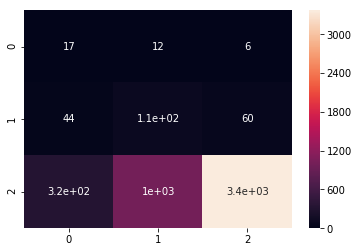

In [109]:
(BERT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
 BERT_TABULAR_MODEL_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        TRAIN_DATAFRAME,
        VALIDATION_DATAFRAME,
        TEST_DATAFRAME,
        VALIDATION_DATAFRAME,
        TRAIN_LABELS_TENSOR,
        VALIDATION_LABELS_TENSOR,
        featurize_bert_tabular_features,
        train_bert_tabular_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'lr': [2e-05],
            'max_epochs': [4],
            'batch_size': [32]
        }
    )
)

In [110]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        BERT_TABULAR_MODEL_TEST_PROBABILITIES,
    ),
    'bert_tabular_model_submissions.csv'
)

### 3.6.5 ULMFiT
This is basically transfer learning onto an AWD-LSTM (used by fastai).

We have to use the fastai API here directly, since the best
implementation I found of this was by Jeremy Howard himself.

Note before we ran the notebook, we used `train_lm.py` (pointing it
to the training data) to fine-tune the existing language model,
which in principle is good at English (WikiText-103) and made transferred
what we knew about English word prediction to predicting RentHop
descriptions, fine tuning on the RentHop description task. This is
different from just using word vectors, since you get the benefit
of the entire language model and contextual information, not just
the vectors themselves.

It is critical here that we load the same vocabulary used to fine
tune the network into the model when we load in the weights. Also,
we need to do the train-test split ourselves, because there
is a bug in the library where the vocabulary is only computed
on the training set and not the validation set, meaning that if the
splits are random you could miss words.

Unfortunately, the fastai API is very involved, making it difficult
to wrap with skortch without breaking stuff, so we have to use it
in a slightly different way to do the same thing. We can also only
report statistics on the first batch, hopefully that should be enough.

epoch,train_loss,valid_loss,accuracy
1,0.764411,0.758924,0.696718
2,0.714020,0.749596,0.695502


epoch,train_loss,valid_loss,accuracy
1,0.746344,0.740853,0.697326


epoch,train_loss,valid_loss,accuracy
1,0.711990,0.746595,0.696110


epoch,train_loss,valid_loss,accuracy
1,0.733127,0.738110,0.697326
2,0.724244,0.742740,0.694895


epoch,train_loss,valid_loss,accuracy
1,0.739647,0.736605,0.696515
2,0.726056,0.737973,0.698541
3,0.704140,0.744042,0.695300
4,0.709743,0.720945,0.700162
5,0.727709,0.729257,0.697731
6,0.697386,0.722816,0.699554
7,0.708255,0.723356,0.698541
8,0.677678,0.728316,0.701175
9,0.694750,0.724349,0.700770
10,0.708457,0.724953,0.700162


Label was 0, classified as 0


,description
521,"xxbos ca nt beat this deal , rent stabilized b..."
635,xxbos st / park ave ! large reno studio w / el...
659,xxbos ( ( ( all photos are actual ! ) ) ) imme...
731,xxbos prime murray hill ! this one of a kind t...
865,xxbos ( ( ( all photos are actual ! ) ) ) all ...


Label was 0, classified as 1


,description
99,xxbos the apartment stunning north facing loft...
177,xxbos this spacious flex bedroom apartment wit...
316,xxbos no fee sprawling luxury building with ho...
350,xxbos wow ! bedroom bath steps from grand cent...
365,xxbos modern converted bedroom in full service...


Label was 0, classified as 2


,description
15,xxbos this is your unique chance to rent a fan...
18,"xxbos no brokers fee $ . cozy corner unit , br..."
29,xxbos the apartment stunning wouth facing stud...
34,xxbos available now must see prime location wi...
47,xxbos this apartment is a third floor walk up ...


Label was 1, classified as 0


,description
1109,xxbos this huge bd apartment is situated in a ...
1133,xxbos ( ( ( all photos are actual ! ) ) ) all ...
1175,xxbos union square special ! this apartment is...
2901,xxbos th / st huge sq real bd charming brownst...
2986,xxbos this is an amazingly priced bedroom / co...


Label was 1, classified as 1


,description
121,xxbos the apartment amazing deal this studio a...
174,xxbos this spacious convertible bedroom apartm...
180,xxbos this spacious convertible apartment with...
215,xxbos this spacious convertible bedroom apartm...
219,xxbos this spacious flex bedroom apartment wit...


Label was 1, classified as 2


,description
6,"xxbos brand new , never lived in one bedroom p..."
13,xxbos take your first step into your new home ...
19,xxbos this spacious bedroom apartment features...
28,xxbos net effective rent $ on a mo lease with ...
35,xxbos this is an incredible rental . it 's a r...


Label was 2, classified as 0


,description
1526,xxbos this renovated gorgeous apartment with?s...
1595,xxbos this renovated gorgeous apartment with?s...
2164,xxbos no fee the high rise hr doorman / concie...
2277,xxbos prime union square .. huge .. sqft .. jr...
3654,xxbos for all people looking for short term le...


Label was 2, classified as 1


,description
112,xxbos the apartment stunning west facing studi...
115,xxbos need a room ? ! april th may st move in ...
173,xxbos this spacious convertible bedroom apartm...
176,xxbos this spacious convertible bedroom apartm...
179,xxbos this spacious studio apartment with city...


Label was 2, classified as 2


,description
0,xxbos note this apartment is located on the th...
1,xxbos spectacular townhouse in historic east v...
2,xxbos live in this amazing new beautiful unrea...
3,"xxbos incredible br , bath in prospect heights..."
4,xxbos what is lorem ipsum?lorem ipsum is simpl...


              precision    recall  f1-score   support

           0       0.06      0.48      0.11        48
           1       0.11      0.43      0.18       294
           2       0.96      0.72      0.82      4594

   micro avg       0.70      0.70      0.70      4936
   macro avg       0.38      0.54      0.37      4936
weighted avg       0.90      0.70      0.78      4936

Logistic loss 0.72495


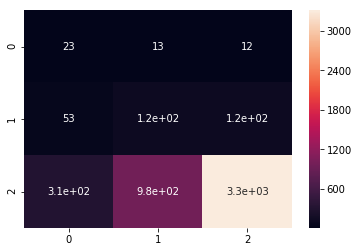

In [112]:
from utils.language_models.ulmfit import train_ulmfit_model_and_get_validation_and_test_set_predictions

(ULMFIT_VALIDATION_PROBABILITIES,
 ULMFIT_TEST_PROBABILITIES) = train_ulmfit_model_and_get_validation_and_test_set_predictions(
    TRAIN_DATAFRAME,
    VALIDATION_DATAFRAME,
    TEST_DATAFRAME
)

In [113]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        ULMFIT_TEST_PROBABILITIES
    ),
    'ulmfit_submissions.csv'
)

### 4 Ensembling

Now that we have all of our models and various predictions, we can
ensemble them together in the form of one big logistic regression model or gradient boosted tree to work out what the "true" classes are based on how all the different models were voting.

Notice that the confusion matrix for each of the models was quite
different - this indicates that each model is probably more biased towards certain features. We can get the predictions for all of our training data and put them together into another dataset which we then apply XGBoost and a linear model to. In principle this allows us to decide amongst the learners by comparing their probability distributions.

We also only do the stacking on the validation set by splitting the validation set again into training and validation data - we don't use the  original training data since that's what the learners themselves were trained on.

In [122]:
(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET,
 STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET,
 _,
 VALIDATION_SPLIT_VALIDATION_DATAFRAME,
 TRAINING_SPLIT_FEATURES_VALIDATION_DATAFRAME,
 VALIDATION_SPLIT_FEATURES_VALIDATION_DATAFRAME,
 STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET,
 STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET) = train_test_split(
    np.column_stack([
        LOGISTIC_REGRESSION_MODEL_VALIDATION_PROBABILITIES,
        XGBOOST_MODEL_VALIDATION_PROBABILITIES,
        RF_MODEL_VALIDATION_PROBABILITIES,
        ADABOOST_MODEL_VALIDATION_PROBABILITIES,
        EXTRATREES_MODEL_VALIDATION_PROBABILITIES,
        SVC_MODEL_VALIDATION_PROBABILITIES,
        SIMPLE_RNN_MODEL_VALIDATION_PROBABILITIES,
        SIMPLE_RNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        FASTTEXT_MODEL_VALIDATION_PROBABILITIES,
        FASTTEXT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        TEXTCNN_MODEL_VALIDATION_PROBABILITIES,
        TEXTCNN_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        BERT_LANG_MODEL_VALIDATION_PROBABILITIES,
        BERT_TABULAR_MODEL_VALIDATION_PROBABILITIES,
        ULMFIT_VALIDATION_PROBABILITIES,
    ]),
    VALIDATION_DATAFRAME,
    FEATURES_VALIDATION_DATAFRAME,
    VALIDATION_LABELS,
    stratify=VALIDATION_LABELS,
    test_size=0.1
)

STACKED_TEST_PREDICTIONS_TEST_SET = np.column_stack([
    LOGISTIC_REGRESSION_MODEL_TEST_PROBABILITIES,
    XGBOOST_MODEL_TEST_PROBABILITIES,
    RF_MODEL_TEST_PROBABILITIES,
    ADABOOST_MODEL_TEST_PROBABILITIES,
    EXTRATREES_MODEL_TEST_PROBABILITIES,
    SVC_MODEL_TEST_PROBABILITIES,
    SIMPLE_RNN_MODEL_TEST_PROBABILITIES,
    SIMPLE_RNN_TABULAR_MODEL_TEST_PROBABILITIES,
    FASTTEXT_MODEL_TEST_PROBABILITIES,
    FASTTEXT_TABULAR_MODEL_TEST_PROBABILITIES,
    TEXTCNN_MODEL_TEST_PROBABILITIES,
    TEXTCNN_TABULAR_MODEL_TEST_PROBABILITIES,
    BERT_LANG_MODEL_TEST_PROBABILITIES,
    BERT_TABULAR_MODEL_TEST_PROBABILITIES,
    ULMFIT_TEST_PROBABILITIES,
])

### 4.1 Ensembling with XGBoost

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.8s finished
[21:39:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Best parameters {'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Label was 0, classified as 0


,description
4198,<center><strong> </strong><br><br> <strong><u>...
3236,Brand new 3 bedroom apt in an all new home wit...
3278,Stunning studio located in the much desired mi...
4262,Enormous 1 bedroom apartment in Murray Hill. F...
3729,DO NOT MISS THIS AMAZING DEAL IN MIDTOWN EAST!...


Label was 0, classified as 1


,description
4183,NO FEE Sprawling luxury building with 24 Hour ...
2436,Renovated 1 Bedroom with your OWN Washer & Dry...
147,This Newly Renovated 3BR Apartment Features Hi...
2692,"This is a real 700 sq ft, 1 bedroom, convertib..."
4687,NO FEE!! - HIGH END - GUT RENOVATED - STUNNING...


Label was 0, classified as 2


,description
3722,This is your unique chance to rent a fantastic...
1132,One block from Prospect Park sits this wonderf...
4433,PRIME LOCATION!! LUXURY BUILDING WITH NEWLY RE...
4355,
3300,This is a mammoth 4-bedroom loft apartment wit...


Label was 1, classified as 0


,description
4803,"Delightful 2 BR in Brooklyn w/ On Site Garage,..."
4140,"Currently under renovation, this 2 bed..."
4036,Great Location! Great Price! Newly renovated t...
4866,This is a huge pre-war building. King sized be...
1752,"Huge 2 Bedroom Railroad, Highly Renovated Tile..."


Label was 1, classified as 1


,description
4807,
4639,4TH ST/ 2 AVENUE!! BEAUTFUL STUDIO WITH HIGH C...
3160,Luxury Upper West Side building located in the...
2305,"Beautiful , bright , big 2 rooms Studio gut n..."
4353,This great 1 Bedroom apartment is conveniently...


Label was 1, classified as 2


,description
953,Beautifully renovated 3 bedroom 2 bath apartme...
1395,***2 BED FLEX 3 BED WITH W/D IN APT_POOL_ GYM_...
4034,Stellar2 bedroom in the heart of the east 70s ...
2683,"Only one flight up, this parlor floor apt is a..."
3471,"Charming Prewar building, located in the heart..."


Label was 2, classified as 0


,description
3912,Bright UES studio apartment! Only two flights ...
4934,This studio is jaw dropping and Gut renovated ...
1684,"Amazing building, high-rise, sunny, offering i..."


Label was 2, classified as 1


,description
724,
1246,Spacious three bedroom apartment encompassing ...
1197,NO FEE. This studio apartment in the high 30's...
1272,STUNNING FLEX 2 BEDROOM APARTMENT LOCATED IN M...
1666,"Rare find, newly gut renovated huge 1 bedroom ..."


Label was 2, classified as 2


,description
3516,"Classic parlor floor, gorgeous one bedroom apa..."
3399,Gut renovated 3 Bedroom Apartment!<br /><br />...
326,This building is located in the prime upper we...
2241,"Amazing studio in a prewar,Full Time Doorman E..."
545,"Stunning Studio High End Luxury in East 70's, ..."


              precision    recall  f1-score   support

           0       0.21      0.44      0.29        18
           1       0.42      0.57      0.48        82
           2       0.94      0.82      0.88       394

   micro avg       0.77      0.77      0.77       494
   macro avg       0.52      0.61      0.55       494
weighted avg       0.83      0.77      0.79       494

Logistic loss 0.54625


None

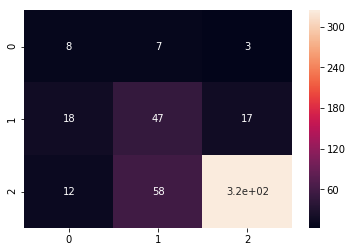

In [124]:
def identity_unpack(*args):
    return _, args

(XGBOOST_MODEL_STACKED_VALIDATION_PROBABILITIES,
 XGBOOST_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
        pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True),
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True),
        identity_unpack,
        train_xgboost_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'colsample_bytree': [0.8],
            'gamma': [2],
            'max_depth': [3],
            'min_child_weight': [5],
            'n_estimators': [100],
            'subsample': [0.8]
        }
    )
)

In [125]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        XGBOOST_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'xgboost_stacked_submissions.csv'
)

### 4.2 Ensembling with Logistic Regression

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.3s finished
Best parameters {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}
Label was 0, classified as 0


,description
4198,<center><strong> </strong><br><br> <strong><u>...
3236,Brand new 3 bedroom apt in an all new home wit...
3278,Stunning studio located in the much desired mi...
4262,Enormous 1 bedroom apartment in Murray Hill. F...
3729,DO NOT MISS THIS AMAZING DEAL IN MIDTOWN EAST!...


Label was 0, classified as 1


,description
4183,NO FEE Sprawling luxury building with 24 Hour ...
2436,Renovated 1 Bedroom with your OWN Washer & Dry...
147,This Newly Renovated 3BR Apartment Features Hi...
4433,PRIME LOCATION!! LUXURY BUILDING WITH NEWLY RE...
4687,NO FEE!! - HIGH END - GUT RENOVATED - STUNNING...


Label was 0, classified as 2


,description
3722,This is your unique chance to rent a fantastic...
1132,One block from Prospect Park sits this wonderf...
2692,"This is a real 700 sq ft, 1 bedroom, convertib..."
4355,
3300,This is a mammoth 4-bedroom loft apartment wit...


Label was 1, classified as 0


,description
4803,"Delightful 2 BR in Brooklyn w/ On Site Garage,..."
2114,"Eco friendly high rise, LOCATED AT THE TOP FLO..."
4036,Great Location! Great Price! Newly renovated t...
2804,


Label was 1, classified as 1


,description
4807,
4639,4TH ST/ 2 AVENUE!! BEAUTFUL STUDIO WITH HIGH C...
3160,Luxury Upper West Side building located in the...
2305,"Beautiful , bright , big 2 rooms Studio gut n..."
4353,This great 1 Bedroom apartment is conveniently...


Label was 1, classified as 2


,description
953,Beautifully renovated 3 bedroom 2 bath apartme...
1395,***2 BED FLEX 3 BED WITH W/D IN APT_POOL_ GYM_...
4034,Stellar2 bedroom in the heart of the east 70s ...
4151,1500+ Sq Ft Recently Renovated TRUE 3 bedroom ...
2683,"Only one flight up, this parlor floor apt is a..."


Label was 2, classified as 0


,description
3912,Bright UES studio apartment! Only two flights ...


Label was 2, classified as 1


,description
1246,Spacious three bedroom apartment encompassing ...
1197,NO FEE. This studio apartment in the high 30's...
1272,STUNNING FLEX 2 BEDROOM APARTMENT LOCATED IN M...
1666,"Rare find, newly gut renovated huge 1 bedroom ..."
4422,"No broker fee! Three bedroom, two bathroom bi ..."


Label was 2, classified as 2


,description
3516,"Classic parlor floor, gorgeous one bedroom apa..."
3399,Gut renovated 3 Bedroom Apartment!<br /><br />...
326,This building is located in the prime upper we...
724,
2241,"Amazing studio in a prewar,Full Time Doorman E..."


              precision    recall  f1-score   support

           0       0.21      0.62      0.31        13
           1       0.38      0.54      0.44        78
           2       0.95      0.81      0.88       403

   micro avg       0.76      0.76      0.76       494
   macro avg       0.51      0.66      0.54       494
weighted avg       0.84      0.76      0.79       494

Logistic loss 0.55605


None

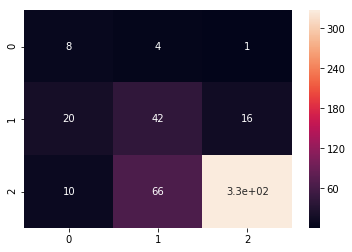

In [128]:
(LOGISTIC_REGRESSION_MODEL_STACKED_VALIDATION_PROBABILITIES,
 LOGISTIC_REGRESSION_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
        pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
        pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True),
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True),
        identity_unpack,
        train_logistic_regression_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'C': [1.0],
            'class_weight': [None],
            'penalty': ['l2']
        }
    )
)

In [129]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        LOGISTIC_REGRESSION_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'logistic_stacked_submissions.csv'
)

### 4.3 Guided Ensembles

We can also try to "guide" the ensembles by concatenating our features and then doing predictions based on that.

Unfortunately this seems to be more of a distraction than a help - we actually perform *worse* on validation set once we start introducing our original data back in.

#### 4.3.1 Guided Ensemble - XGBoost

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s finished
[21:55:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Best parameters {'colsample_bytree': 0.6, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Label was 0, classified as 0


,description
4198,<center><strong> </strong><br><br> <strong><u>...
3278,Stunning studio located in the much desired mi...
4262,Enormous 1 bedroom apartment in Murray Hill. F...
3729,DO NOT MISS THIS AMAZING DEAL IN MIDTOWN EAST!...
2412,It is not a question of if you want to live Do...


Label was 0, classified as 1


,description
3236,Brand new 3 bedroom apt in an all new home wit...
4183,NO FEE Sprawling luxury building with 24 Hour ...
2436,Renovated 1 Bedroom with your OWN Washer & Dry...
147,This Newly Renovated 3BR Apartment Features Hi...
3300,This is a mammoth 4-bedroom loft apartment wit...


Label was 0, classified as 2


,description
3722,This is your unique chance to rent a fantastic...
1132,One block from Prospect Park sits this wonderf...
2692,"This is a real 700 sq ft, 1 bedroom, convertib..."
4433,PRIME LOCATION!! LUXURY BUILDING WITH NEWLY RE...
4355,


Label was 1, classified as 0


,description
4803,"Delightful 2 BR in Brooklyn w/ On Site Garage,..."
4036,Great Location! Great Price! Newly renovated t...
4,Renovated cozy studio on elevator building in ...
1752,"Huge 2 Bedroom Railroad, Highly Renovated Tile..."
2804,


Label was 1, classified as 1


,description
4807,
4639,4TH ST/ 2 AVENUE!! BEAUTFUL STUDIO WITH HIGH C...
3160,Luxury Upper West Side building located in the...
2305,"Beautiful , bright , big 2 rooms Studio gut n..."
4353,This great 1 Bedroom apartment is conveniently...


Label was 1, classified as 2


,description
953,Beautifully renovated 3 bedroom 2 bath apartme...
1395,***2 BED FLEX 3 BED WITH W/D IN APT_POOL_ GYM_...
4034,Stellar2 bedroom in the heart of the east 70s ...
2683,"Only one flight up, this parlor floor apt is a..."
4771,"A brown-brick, prewar building located in Midt..."


Label was 2, classified as 0


,description
3912,Bright UES studio apartment! Only two flights ...


Label was 2, classified as 1


,description
1197,NO FEE. This studio apartment in the high 30's...
1272,STUNNING FLEX 2 BEDROOM APARTMENT LOCATED IN M...
1666,"Rare find, newly gut renovated huge 1 bedroom ..."
4422,"No broker fee! Three bedroom, two bathroom bi ..."
1860,The perfect opportunity to experience luxury l...


Label was 2, classified as 2


,description
3516,"Classic parlor floor, gorgeous one bedroom apa..."
3399,Gut renovated 3 Bedroom Apartment!<br /><br />...
326,This building is located in the prime upper we...
724,
2241,"Amazing studio in a prewar,Full Time Doorman E..."


              precision    recall  f1-score   support

           0       0.21      0.57      0.31        14
           1       0.40      0.57      0.47        79
           2       0.95      0.82      0.88       401

   micro avg       0.77      0.77      0.77       494
   macro avg       0.52      0.65      0.55       494
weighted avg       0.84      0.77      0.80       494

Logistic loss 0.53784


None

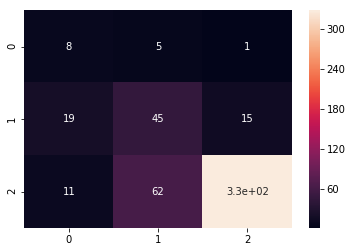

In [132]:
(GUIDED_XGBOOST_MODEL_STACKED_VALIDATION_PROBABILITIES,
 GUIDED_XGBOOST_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
                   TRAINING_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
                   VALIDATION_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
                   FEATURES_TEST_DATAFRAME.reset_index().drop("index", axis=1)), axis=1),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True),
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True),
        featurize_for_tree_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_xgboost_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'colsample_bytree': [0.6],
            'gamma': [2],
            'max_depth': [3],
            'min_child_weight': [1],
            'n_estimators': [100],
            'subsample': [0.8]
        }
    )
)

In [133]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        GUIDED_XGBOOST_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'guided_xgboost_stacked_submissions.csv'
)

#### 4.3.2 Guided Ensemble - Logistic Regression

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    4.5s finished
Best parameters {'C': 1.0, 'class_weight': None, 'penalty': 'l2'}
Label was 0, classified as 0


,description
3236,Brand new 3 bedroom apt in an all new home wit...
3278,Stunning studio located in the much desired mi...
4183,NO FEE Sprawling luxury building with 24 Hour ...
3729,DO NOT MISS THIS AMAZING DEAL IN MIDTOWN EAST!...
2574,Luxury Upper West Side building located in the...


Label was 0, classified as 1


,description
4198,<center><strong> </strong><br><br> <strong><u>...
4262,Enormous 1 bedroom apartment in Murray Hill. F...
1132,One block from Prospect Park sits this wonderf...
2436,Renovated 1 Bedroom with your OWN Washer & Dry...
147,This Newly Renovated 3BR Apartment Features Hi...


Label was 0, classified as 2


,description
3722,This is your unique chance to rent a fantastic...
2692,"This is a real 700 sq ft, 1 bedroom, convertib..."
4433,PRIME LOCATION!! LUXURY BUILDING WITH NEWLY RE...
4355,
2149,LOOK NO FURTHER!!\r\rIncredible corner studio ...


Label was 1, classified as 0


,description
4803,"Delightful 2 BR in Brooklyn w/ On Site Garage,..."
4140,"Currently under renovation, this 2 bed..."
4036,Great Location! Great Price! Newly renovated t...
753,NO FEE!! Stunning modern 24/7 doorman building...
1098,AMAZING 3 BEDROOM APARTMENT IN LUXURY 24HR DOO...


Label was 1, classified as 1


,description
4807,
4639,4TH ST/ 2 AVENUE!! BEAUTFUL STUDIO WITH HIGH C...
3160,Luxury Upper West Side building located in the...
2305,"Beautiful , bright , big 2 rooms Studio gut n..."
4353,This great 1 Bedroom apartment is conveniently...


Label was 1, classified as 2


,description
953,Beautifully renovated 3 bedroom 2 bath apartme...
1395,***2 BED FLEX 3 BED WITH W/D IN APT_POOL_ GYM_...
4034,Stellar2 bedroom in the heart of the east 70s ...
2683,"Only one flight up, this parlor floor apt is a..."
4771,"A brown-brick, prewar building located in Midt..."


Label was 2, classified as 0


,description
1666,"Rare find, newly gut renovated huge 1 bedroom ..."
1860,The perfect opportunity to experience luxury l...
3912,Bright UES studio apartment! Only two flights ...
4934,This studio is jaw dropping and Gut renovated ...


Label was 2, classified as 1


,description
724,
1246,Spacious three bedroom apartment encompassing ...
1519,THIS AMAZING CONV 3 BED PALACE IS READY FOR IM...
2490,Large studio apartment in the heart of Chelse...
1197,NO FEE. This studio apartment in the high 30's...


Label was 2, classified as 2


,description
3516,"Classic parlor floor, gorgeous one bedroom apa..."
3399,Gut renovated 3 Bedroom Apartment!<br /><br />...
326,This building is located in the prime upper we...
2241,"Amazing studio in a prewar,Full Time Doorman E..."
545,"Stunning Studio High End Luxury in East 70's, ..."


              precision    recall  f1-score   support

           0       0.24      0.39      0.30        23
           1       0.45      0.50      0.47       100
           2       0.89      0.83      0.86       371

   micro avg       0.74      0.74      0.74       494
   macro avg       0.53      0.57      0.54       494
weighted avg       0.77      0.74      0.75       494

Logistic loss 0.58554


None

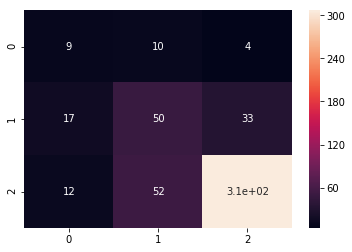

In [137]:
(GUIDED_LOGISTIC_MODEL_STACKED_VALIDATION_PROBABILITIES,
 GUIDED_LOGISTIC_MODEL_STACKED_TEST_PROBABILITIES) = gc_and_clear_caches(
    train_model_and_get_validation_and_test_set_predictions(
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_TRAINING_SET),
                   TRAINING_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_VALIDATION_PREDICTIONS_VALIDATION_SET),
                   VALIDATION_SPLIT_FEATURES_VALIDATION_DATAFRAME.reset_index().drop(["index"], axis=1)), axis=1),
        pd.concat((pd.DataFrame(STACKED_TEST_PREDICTIONS_TEST_SET),
                   FEATURES_TEST_DATAFRAME.reset_index().drop("index", axis=1)), axis=1),
        VALIDATION_SPLIT_VALIDATION_DATAFRAME,
        STACKED_VALIDATION_PREDICTIONS_LABELS_TRAINING_SET.reset_index(drop=True),
        STACKED_VALIDATION_PREDICTIONS_LABELS_VALIDATION_SET.reset_index(drop=True),
        featurize_for_tabular_models(DROP_COLUMNS, CATEGORICAL_FEATURES),
        train_logistic_regression_model,
        predict_with_sklearn_estimator,
        train_param_grid_optimal={
            'C': [1.0],
            'class_weight': [None],
            'penalty': ['l2']
        }
    )
)

In [138]:
write_predictions_table_to_csv(
    get_prediction_probabilities_with_columns_from_predictions(
        FEATURES_TEST_DATAFRAME['listing_id'],
        GUIDED_LOGISTIC_MODEL_STACKED_TEST_PROBABILITIES
    ),
    'guided_logistic_stacked_submissions.csv'
)

## 5 Conclusions

With all the work that we did, we were able to reduce the validation loss from a baseline linear model $\approx 0.63$ to a much better $\approx 0.537$.

Ensembling provided us the biggest benefit - we were able to combine all the knowledge we gained from different learners over different parts of the training data to make better classifications over the validation data.

I was able to apply quite a lot of the knowledge I gained from this course into forming my model. In particular:
 * Where to look for guidance on the competition (eg, the forums, winning kernels, etc)
 * A better exploratory data analysis using Seaborn crossplots to look at correlation between the numerical features.
 * Feature engineering on numerical data by performing simple math, this helps decision tree based models that can't do this kind of transformation inherently.
 * Correct usage of sklearn - even though I wasn't able to use Pipelines very effectively, I was able to make use of meta-estimators like grid-search and leverage the estimator API.
 * Usage of ensembling methods - as stated before, the use of ensembling over may different methods provided quite a large benefit. I am sure that this benefit would have been even greater if we used bagging or boosting on the actual estimators themselves with subsets of the training data, though I didn't have enough time to implement that properly.
 * Through my own research, I learned quite a lot about language models and text classification approaches (FastText, TextCNN, BERT).